In [104]:
from torch.utils import data as D
import torch
import torch.nn as nn
import torch.nn.functional as F

from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, rdMolDescriptors, Draw
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.Scaffolds import MurckoScaffold
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import warnings
import pickle

from rdkit.ML.Scoring import Scoring
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.dummy import DummyClassifier
from scipy.stats import gamma

In [81]:
from sklearn.metrics import (matthews_corrcoef, 
                             confusion_matrix, 
                             f1_score, 
                             roc_auc_score,
                             accuracy_score,
                             auc, precision_recall_curve, roc_curve)

## Import the training, validation and test datasets

In [133]:
with open('idx_to_target_name_no_dups.pcl','rb') as f:
    idx_to_target_name = pickle.load(f)

In [5]:
with open('only_unique_examples_data/train_labels_and_smiles.pcl', 'rb') as f:
    [train_labels, train_smiles] = pickle.load( f)
    
with open('only_unique_examples_data/val_labels_and_smiles.pcl', 'rb') as f:
    [val_labels, val_smiles] = pickle.load(f)
    
with open('only_unique_examples_data/test_labels_and_smiles.pcl', 'rb') as f:
    [test_labels, test_smiles] = pickle.load( f)

In [6]:
class ChEMBLDataset(D.Dataset):
    
    def __init__(self, smiles_list, labels, radius_fp=2, length_of_fp=2048, mask_id=0):
        """
        The dataset is constructed such that the mask provides a convenient way to access features and label for each target.
        """
        self.mask_id = mask_id
        self.smiles_list = smiles_list
        self.n_tasks = len(self.smiles_list)
        self.labels = labels
        self.all_mols_list = self.preprocess_molecules()
        self.bv_fps = []
        self.fps = []
        self.bv_pos_fps = []
        
        for i in range(self.n_tasks):
            tmp = [self.calc_fp(mol, 2048, 2) for mol in self.all_mols_list[i]]
            tmp2 = [self.calc_fp_bv(mol, 2048, 2) for mol in self.all_mols_list[i]]
            mask = np.where(self.labels[i] == 1., True, False)
            mask = sum(mask)
            self.fps.append(tmp)
            self.bv_fps.append(tmp2)
            self.bv_pos_fps.append(tmp2[:mask])
        self.fps = np.array(self.fps)
        
    def preprocess_molecules(self):
        """
        Preprocessing of molecules - standardises, neutralises and canonicalises molecules.
        """
        all_mols_list = []
        all_failed = []
        for j in range(self.n_tasks):
            failed = []
            mols_list = []
            for i,smiles in tqdm(enumerate(self.smiles_list[j])):
                try:
                    mol = Chem.MolFromSmiles(smiles)

                    clean_mol = rdMolStandardize.Cleanup(mol) 

                    parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)

                    uncharger = rdMolStandardize.Uncharger() # annoying, but necessary as no convenience method exists
                    uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)
                    te = rdMolStandardize.TautomerEnumerator() 
                    taut_uncharged_parent_clean_mol = te.Canonicalize(uncharged_parent_clean_mol)
                    mols_list.append(taut_uncharged_parent_clean_mol)
                except Exception as e:
                    print(repr(e))
                    failed.append(i)
            all_mols_list.append(mols_list)
            all_failed.append(failed)
        
        for j in range(self.n_tasks):
            self.smiles_list[j] = np.delete(self.smiles_list[j],all_failed[j])
            self.labels[j] = np.delete(self.labels[j],all_failed[j])
     
        return all_mols_list
    
    def calc_fp(self, mol, fp_size, radius):
        """
        Calculates morgan fingerprints as a numpy array.
        """
        mol.UpdatePropertyCache(False)
        Chem.GetSSSR(mol)
        fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius, nBits=fp_size, useChirality=True)
        a = np.zeros((0,), dtype=np.float32)
        Chem.DataStructs.ConvertToNumpyArray(fp, a)
        return a
    
    def calc_fp_bv(self, mol, fp_size, radius):
        """
        Calculates morgan fingerprints as a BV.
        """
        mol.UpdatePropertyCache(False)
        Chem.GetSSSR(mol)
        fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius, nBits=fp_size, useChirality=True)
        return fp
    
    def __len__(self):
        return len(self.fps[self.mask_id])
    
    def change_mask(self, mask_id):
        self.mask_id = mask_id
    
    def __getitem__(self, index):
        return self.fps[self.mask_id][index], self.labels[self.mask_id][index]

### The captures I am using to not print out messages that come from the standardisation of molecules by RDKit

In [7]:
%%capture train
train_dataset = ChEMBLDataset(train_smiles, train_labels, )

In [8]:
%%capture val
val_dataset = ChEMBLDataset(val_smiles, val_labels, );

In [9]:
%%capture test
test_dataset = ChEMBLDataset(test_smiles, test_labels, );

## EDA

In [28]:
all_fps = []
all_labels = []
for head in range(9):
    fps_ = np.concatenate((train_dataset.fps[head], val_dataset.fps[head], test_dataset.fps[head]))
    all_fps.append(fps_)
    labels = np.concatenate((train_dataset.labels[head], val_dataset.labels[head], test_dataset.labels[head]))
    all_labels.append(labels)

In [45]:
intra_neg_pos_simis_per_target = []
for head in range(9):
    simi = []
    curr_target = np.concatenate((train_dataset.all_mols_list[head],val_dataset.all_mols_list[head], test_dataset.all_mols_list[head]))
    curr_fp = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, useChirality=True) for mol in curr_target]
    curr_labels = np.concatenate((train_dataset.labels[head], val_dataset.labels[head], test_dataset.labels[head]))
    for fp, label in tqdm(zip(curr_fp, curr_labels)):
        if label == 1:
            for fp2, label2 in zip(curr_fp, curr_labels):
                if label2 == 0.:
                    simi.append(DataStructs.TanimotoSimilarity(fp, fp2))
    intra_neg_pos_simis_per_target.append(simi)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [52]:
intra_pos_simis_per_target = []
    
for head in range(9):
    simi = []
    curr_target = np.concatenate((train_dataset.all_mols_list[head],val_dataset.all_mols_list[head], test_dataset.all_mols_list[head]))
    curr_fp = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, useChirality=True) for mol in curr_target]
    curr_labels = np.concatenate((train_dataset.labels[head], val_dataset.labels[head], test_dataset.labels[head]))
    for i, (fp, label) in tqdm(enumerate(zip(curr_fp[:-1], curr_labels[:-1]))):
        if label == 1:
            for fp2, label2 in zip(curr_fp[i+1:], curr_labels[i+1:]):
                if label2 == 1.:
                    simi.append(DataStructs.TanimotoSimilarity(fp, fp2))
    intra_pos_simis_per_target.append(simi)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

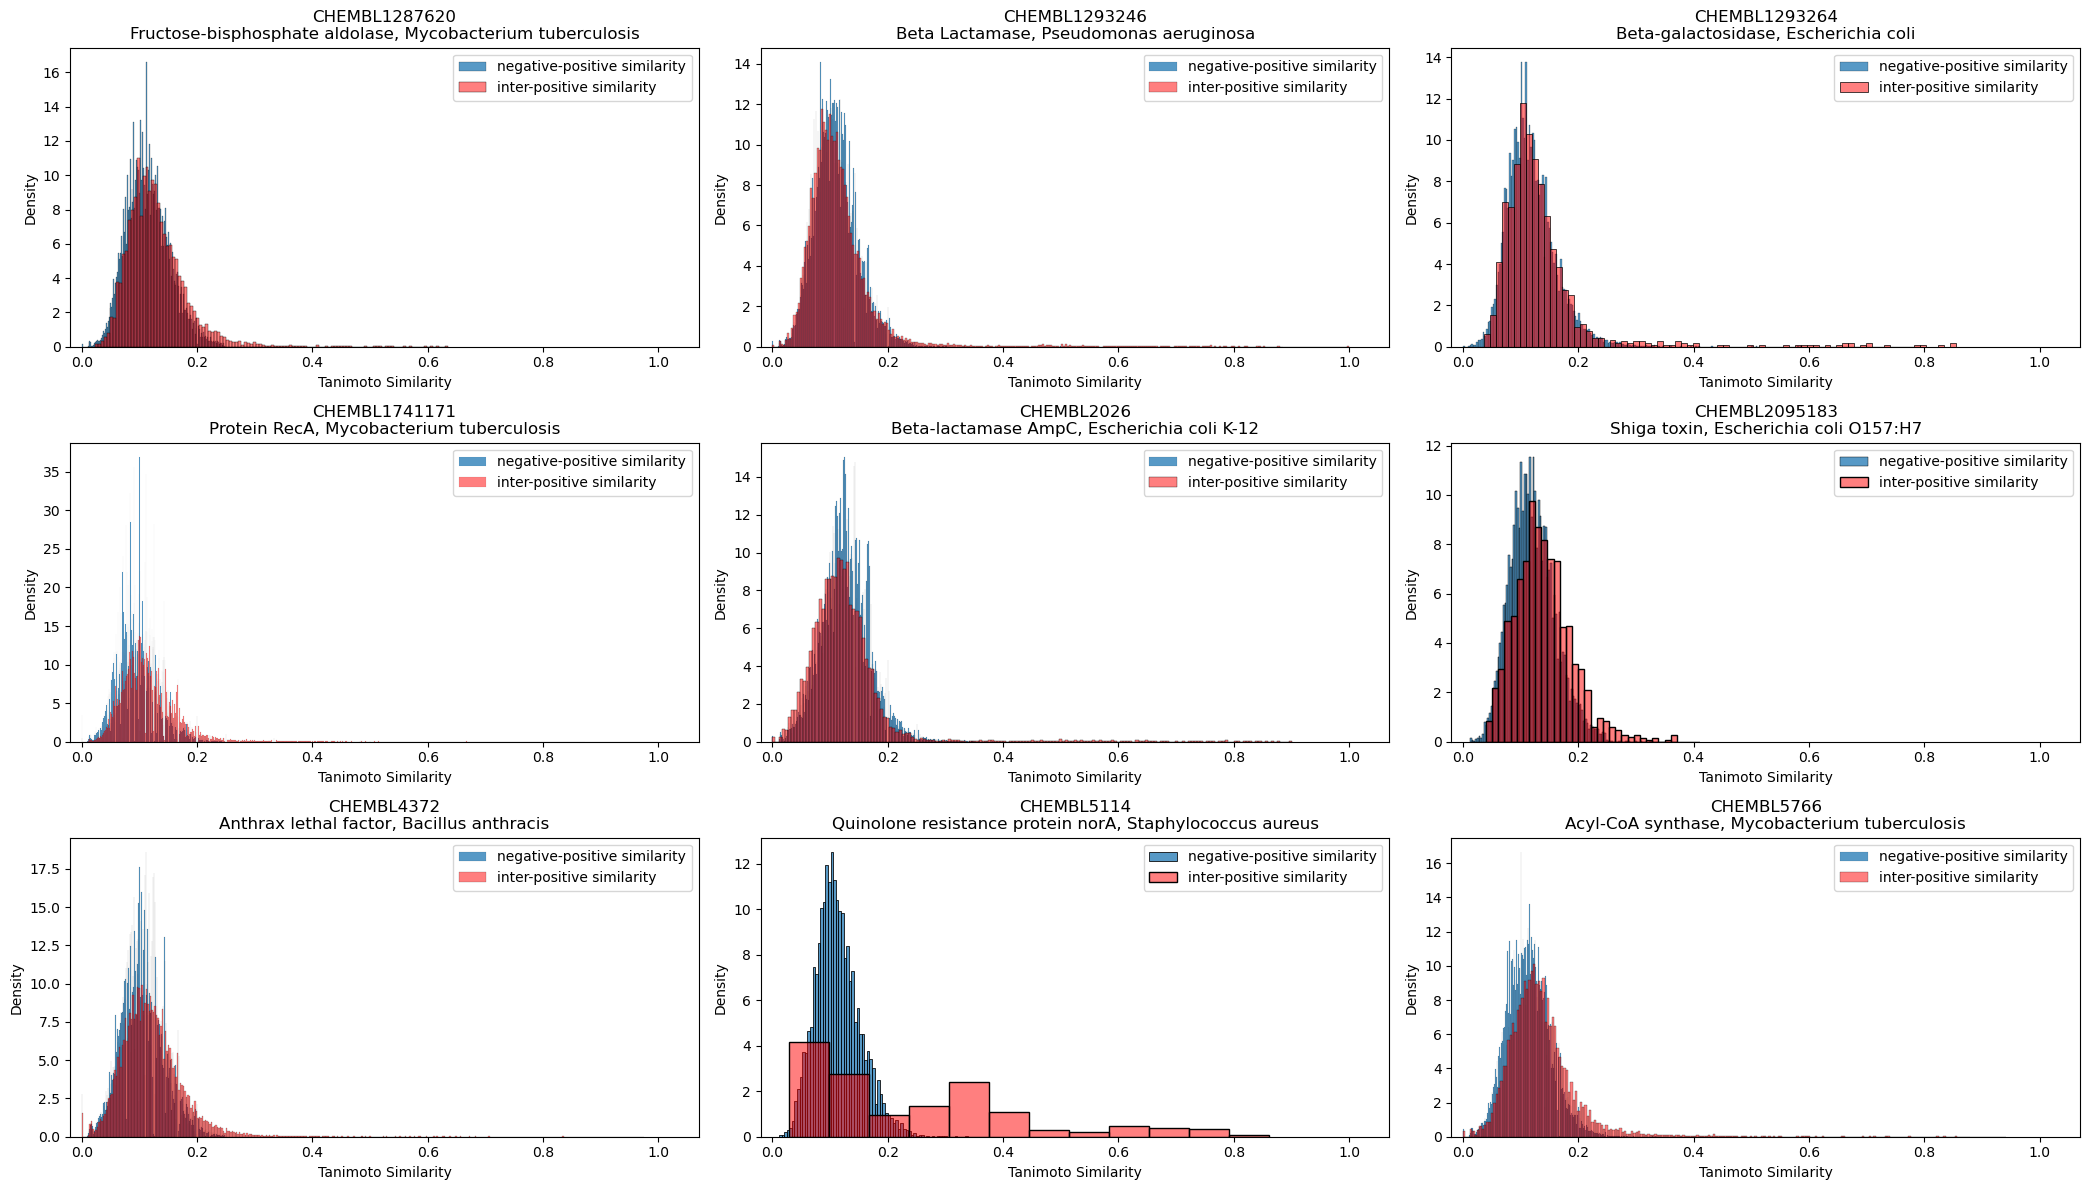

In [53]:
fig, axs = plt.subplots(nrows=3, ncols=3,figsize = (21,12))

for head, ax in zip(range(9), axs.ravel()):
    sn.histplot(x=intra_neg_pos_simis_per_target[head], stat='density', ax=ax,label='negative-positive similarity')
    sn.histplot(x=intra_pos_simis_per_target[head], stat='density', ax=ax, color='red', alpha=0.5, label='inter-positive similarity')
    ax.set_xlabel('Tanimoto Similarity')
    ax.legend()
    ax.set_xlim((-.02, 1.07))
    
    ax.set_title(idx_to_target_name[head])
    plt.tight_layout()
plt.savefig('pictures_2/similarity_of_negatives_to_positives_overlapped_after_enrichment.png')

## The following plot of the chemical space is not really meaningful because the explained variance is less than 5%
### The better way to do it is to reduce the dimensions to 50 (this has about 40-50% of the variance, I have tested that) and then to do t-SNE. However, my laptop crashed twice when I was trying to do that, so I have left it like that
I have included it because people normally do.

In [ ]:
pca = PCA(n_components=2)
pca = pca.fit(np.concatenate(all_fps))

In [18]:
crds_df = pd.DataFrame(crds,columns=["PC_1","PC_2"])

In [23]:
crds_df['Is Active?'] = list(np.concatenate((train_dataset.labels[0], val_dataset.labels[0], test_dataset.labels[0])))

In [36]:
pca.explained_variance_ratio_

array([0.02243734, 0.01912613], dtype=float32)

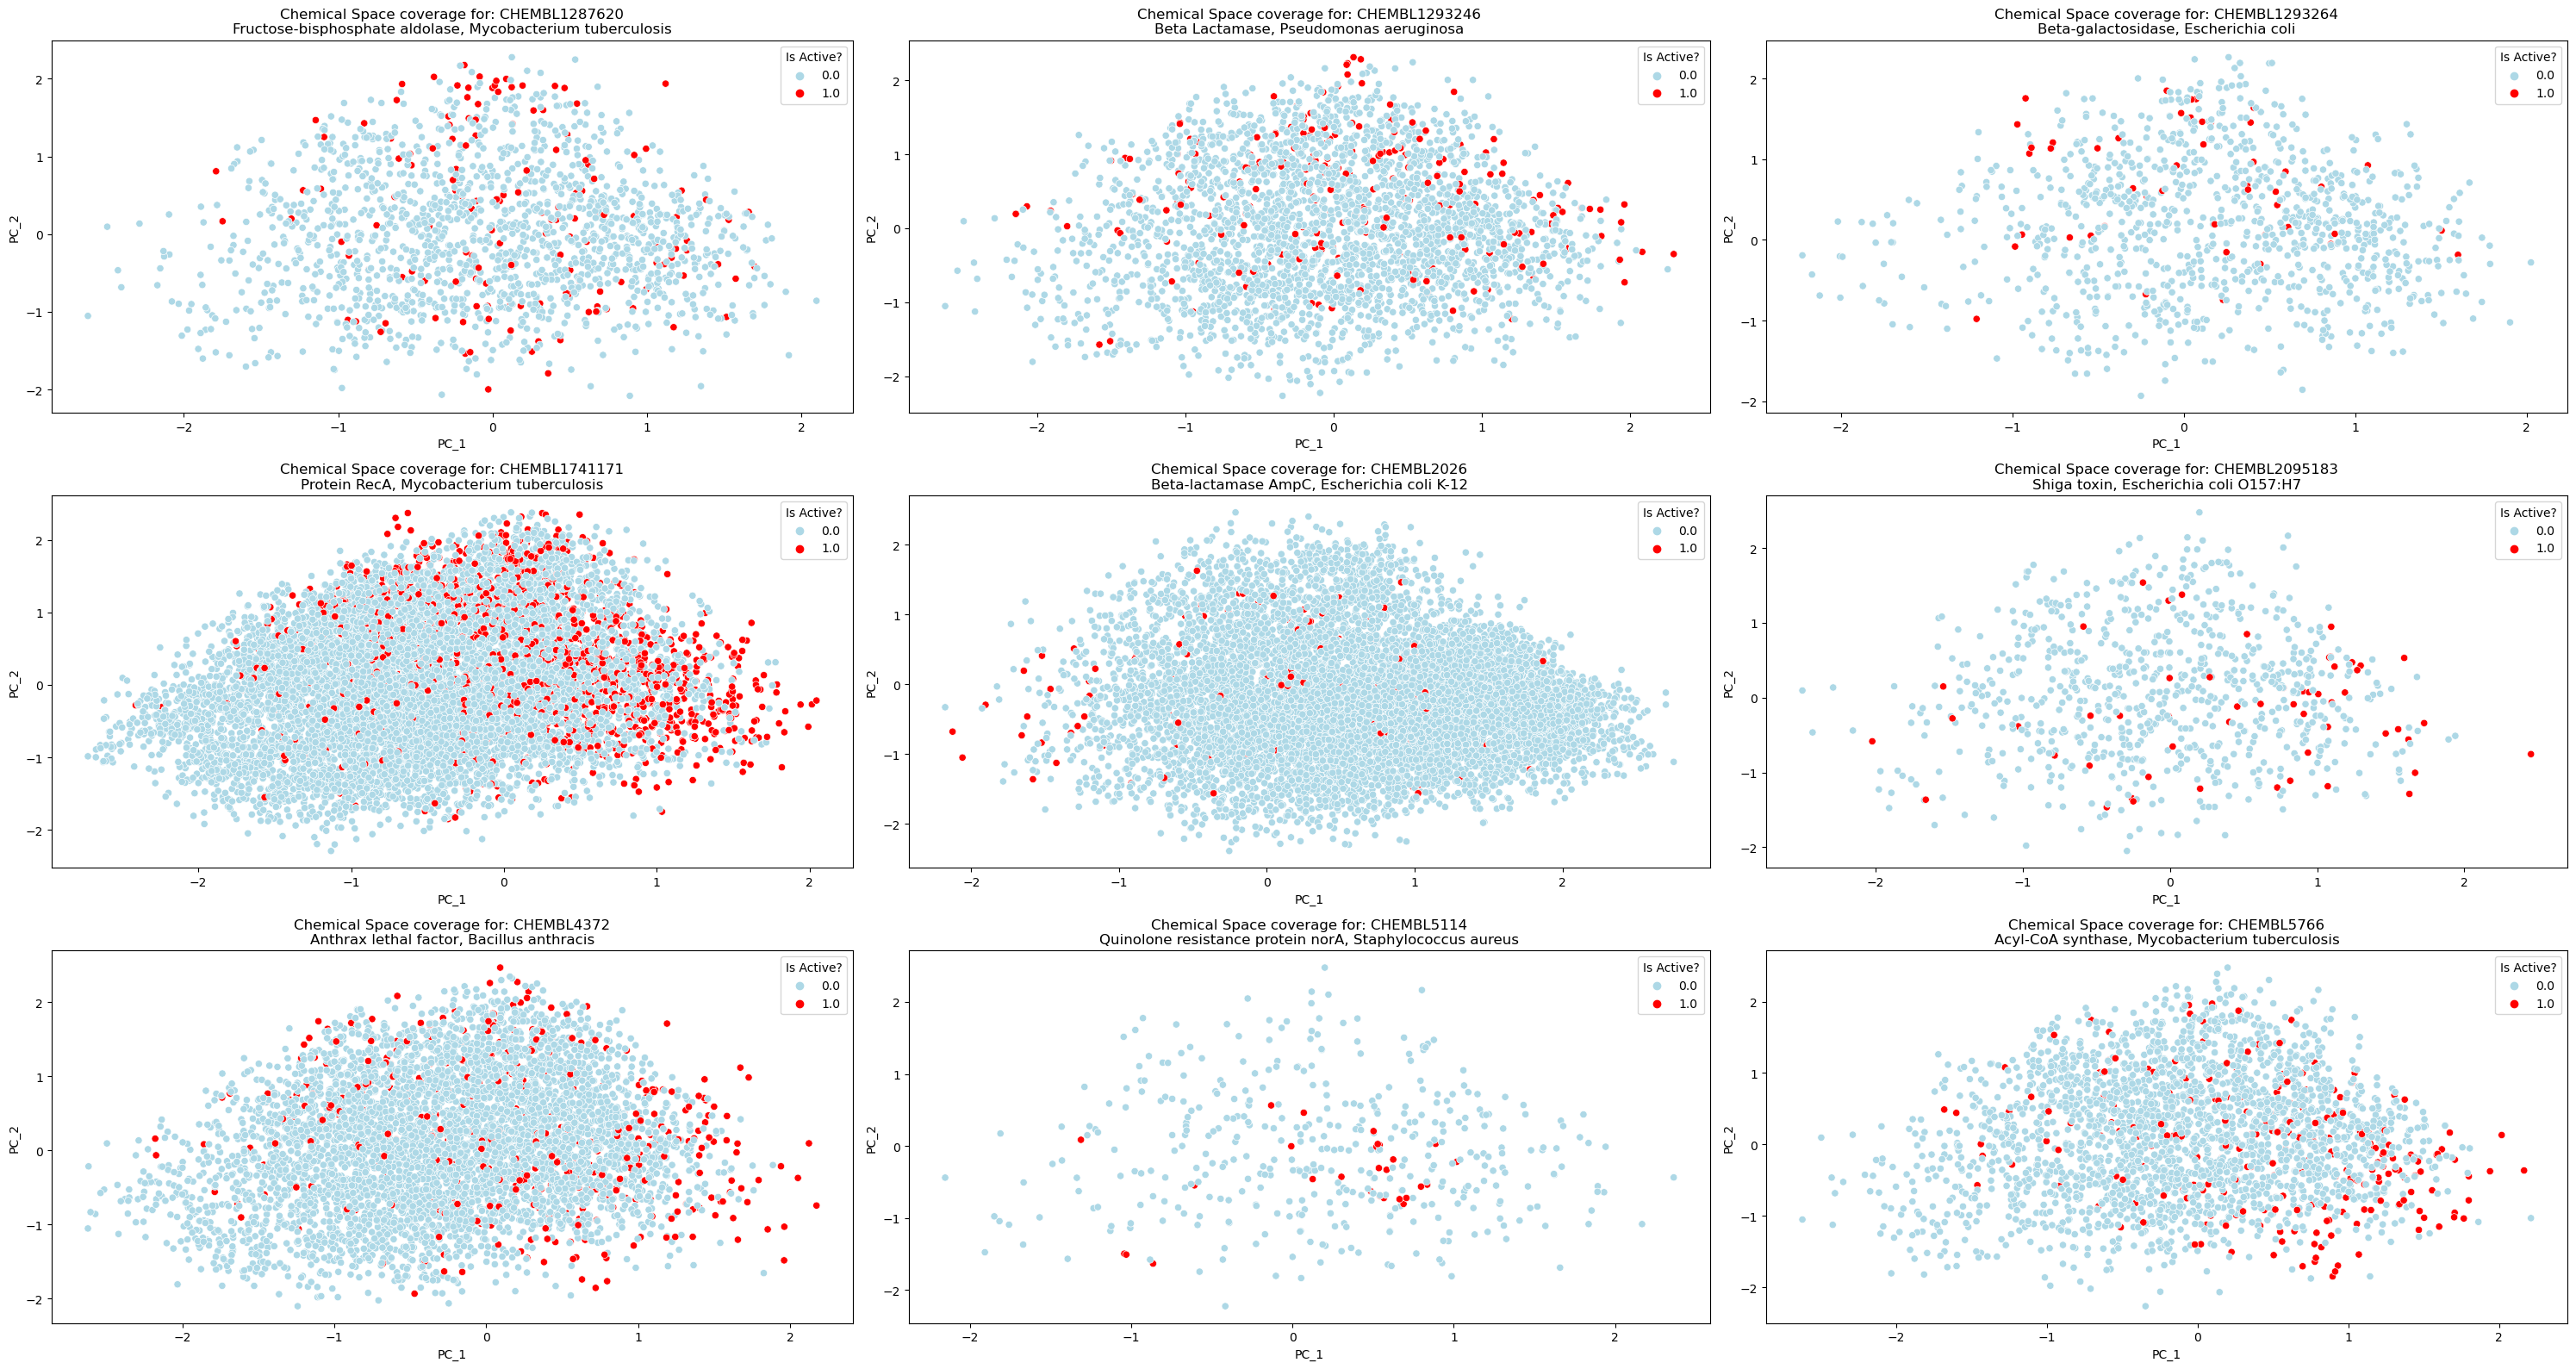

In [40]:
fig, axs = plt.subplots(nrows=3,ncols=3,figsize=(30, 16))
for head, ax in zip(range(9), axs.ravel()):
    crds = pca.transform(all_fps[head])
    crds_df = pd.DataFrame(crds,columns=["PC_1","PC_2"])
    crds_df['Is Active?'] = all_labels[head]
    sn.scatterplot(data=crds_df,x="PC_1",y="PC_2",hue="Is Active?",palette={0:'lightblue',1:'red'}, ax=ax)
    ax.set_title(f'Chemical Space coverage for: {idx_to_target_name[head]}')
    plt.tight_layout()
plt.savefig('pictures_2/chemical_space_all.png')

In [56]:
## Global parameters of the model
BATCH_SIZE = 32  # based on https://arxiv.org/abs/1804.07612
LR = 0.0002
MODEL_PATH = 'only_unique_examples_data/model_fp2_2048_0002.pcl'

In [62]:
## Reproducibility
g = torch.Generator()
g.manual_seed(42)
train_loader = D.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=g)

val_loader = D.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=g)

test_loader = D.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=g)

## Look at the number of molecules in the datasets

In [199]:
idx_to_stats = {} # keeps track of numbers of actives and decoys for training
num_positives = 0
num_negatives = 0
for head in range(9):
    test_dataset.change_mask(head)
    length = len(test_dataset)
    num_positive = sum(test_dataset.labels[head])
    pos_perc = num_positive / length
    idx_to_stats[head] = num_positive, length-num_positive, round(pos_perc, 3)
    num_positives += num_positive
    num_negatives += length-num_positive

In [197]:
idx_to_stats

{0: (22.0, 223.0, 0.09),
 1: (31.0, 389.0, 0.074),
 2: (7.0, 144.0, 0.046),
 3: (249.0, 1224.0, 0.169),
 4: (22.0, 1303.0, 0.017),
 5: (8.0, 111.0, 0.067),
 6: (69.0, 712.0, 0.088),
 7: (4.0, 58.0, 0.065),
 8: (34.0, 343.0, 0.09)}

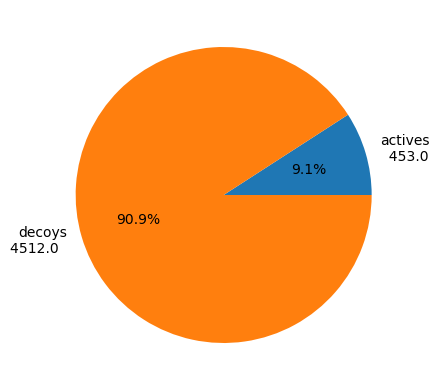

In [193]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 4))
axs.pie([num_positives,num_negatives], labels=[f'actives\n  {num_positives}', f'decoys\n{num_negatives}  '], autopct=lambda pct: str(round(pct, 1)) + "%")
plt.tight_layout()
plt.savefig('pictures_2/train_all_pie.png')

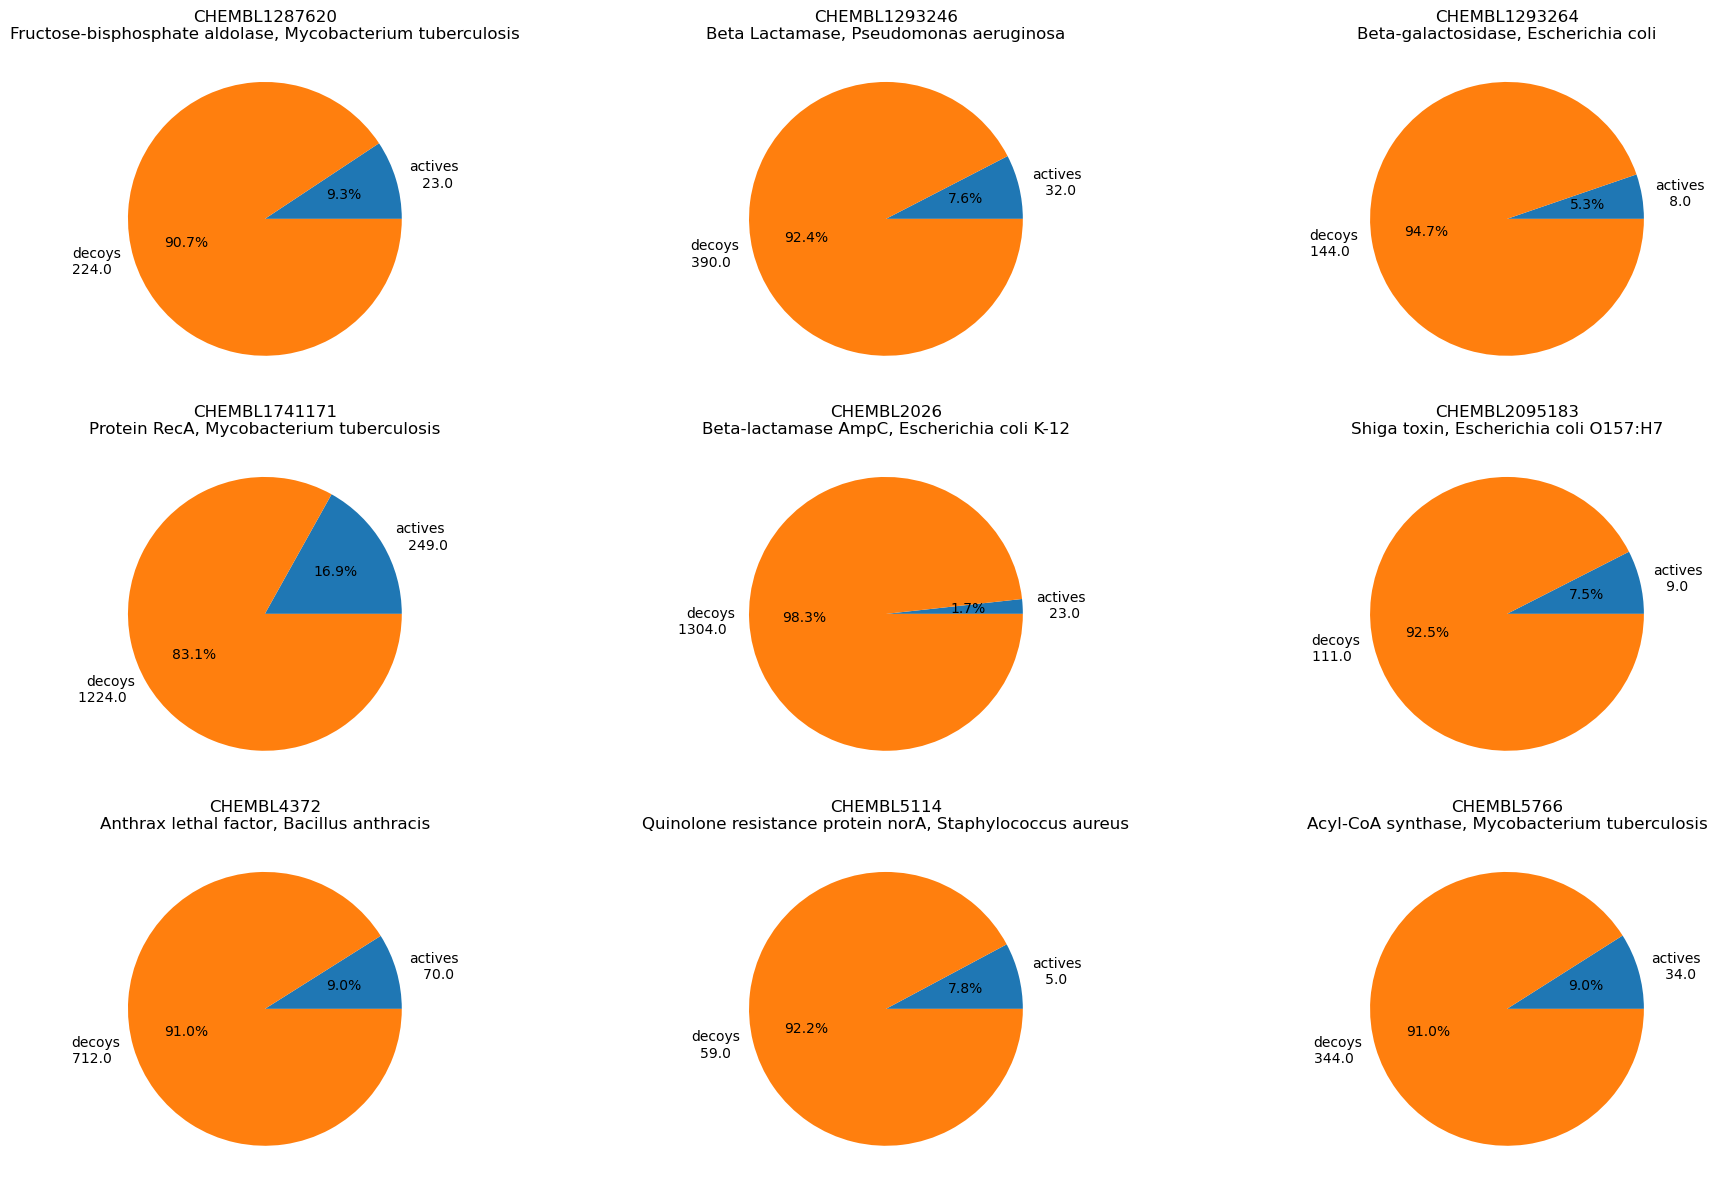

In [200]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 12))
for head, ax in zip(range(9), axs.ravel()):
    ax.pie(idx_to_stats[head][:2], labels=[f'actives\n   {round(idx_to_stats[head][0], 0)}', f'decoys\n{round(idx_to_stats[head][1], 0)}  '],autopct=lambda pct: str(round(pct, 1)) + "%" )
    ax.set_title(idx_to_target_name[head])
plt.tight_layout()
    
plt.savefig('pictures_2/test_set_pie.png')

## Weights for the loss are 1/number of examples. Targets with more examples are given lower weight as there are plenty of examples to learn from that contribute to the loss. Positive weighting to help with the class imbalance (puts more weight on the underrepresented positive class).

In [57]:
weights = []
pos_weights = []
for head in range(train_dataset.n_tasks):
    train_dataset.change_mask(head)
    weights.append(1 / len(train_dataset))
    print(len(train_dataset))
    num_pos = sum(train_dataset.labels[head])
    num_neg = len(train_dataset) - num_pos
    pos_weights.append(num_neg / num_pos)
weights = torch.tensor(weights)
tot = sum(weights)
for i in range(len(weights)):
    weights[i] /= tot

1145
1964
703
6871
6183
553
3643
289
1760


In [58]:
class ChEMBLMultiTask(nn.Module):
    """
    Architecture borrowed from: https://www.nature.com/articles/s41598-022-23203-y#ref-CR13
    """
    def __init__(self, n_tasks):
        super(ChEMBLMultiTask, self).__init__()
        self.n_tasks = n_tasks
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.dropout = nn.Dropout(0.5)

        # add an independet output for each task int the output laer
        for n_m in range(self.n_tasks):
            self.add_module(f"y{n_m}o", nn.Linear(128, 1))
        
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        out = [getattr(self, f"y{n_m}o")(x) for n_m in range(self.n_tasks)]
        return out
    
# create the model
model = ChEMBLMultiTask(val_dataset.n_tasks)

# the negative frequency for a class is the positive weighting for the loss
criterion = [nn.BCEWithLogitsLoss(weight=w, pos_weight=torch.tensor(pw, dtype=torch.float32)) for x, w, pw in zip(range(val_dataset.n_tasks), weights, pos_weights)]

# stochastic gradient descend as an optimiser
optimizer = torch.optim.Adam(model.parameters(), LR)

In [848]:
def train(model, loader, optimizer, criterions):
    """
    Executes a training epoch.
    """
    model.train()
    tot_loss = 0
    loss_by_target = {}
    for head in range(loader.dataset.n_tasks):
        loader.dataset.change_mask(head)
        optimizer.zero_grad()
        loss_by_target[head] = 0
        
        #curr_loss = 0
        loss = torch.tensor(0.)
        for i, (X, y) in enumerate(loader):
            y_hat = model(X)
            loss_head = criterions[head](y_hat[head], torch.tensor(y, dtype=torch.float).view(-1, 1))
            loss += loss_head
            loss_by_target[head] += loss_head.item()
            
        loss.backward()
        optimizer.step()
        tot_loss += loss.item()
    return tot_loss, loss_by_target

In [66]:
def test(model, loader, criterions):
    """
    Executes a testing epoch and keeps track of varius metrics.
    """
    model.eval()
    predictions = {i:np.array([]) for i in range(loader.dataset.n_tasks)} # predicted labels for each tarrget
    pred_probas = {i:[] for i in range(loader.dataset.n_tasks)} # predicted probabilities
    trues = {i:[] for i in range(loader.dataset.n_tasks)} # true labels
    sorteds = {i:[] for i in range(loader.dataset.n_tasks)} # sorted labels (to be used with ranking metrics)

    f1s, mccs, auprcs, aurocs = [], [],[],[]
    bedrocs, random_bedrocs = [], []
    sigm = nn.Sigmoid()
    loss_by_target = {}
    
    tot_loss = 0
    with torch.no_grad():
        for head in range(loader.dataset.n_tasks):
            loss_by_target[head] = 0
            loader.dataset.change_mask(head)
            loss = torch.tensor(0.)
            for i, (X, y) in enumerate(loader):
                y_hat = model(X)
                loss_head = criterions[head](y_hat[head], torch.tensor(y, dtype=torch.float).view(-1, 1))
                loss += loss_head
                loss_by_target[head] += loss_head.item()
                pred_probas[head].extend(sigm(y_hat[head].detach().cpu().view(-1)))
                trues[head].extend(torch.tensor(y, dtype=torch.float))
            
            predictions[head] = torch.where(torch.tensor(pred_probas[head]) > 0.5, torch.ones(1), torch.zeros(1)).view(-1)
            tn, fp, fn, tp = confusion_matrix(trues[head], predictions[head]).ravel()
            sens = tp / (tp + fn)
            spec = tn / (tn + fp)
            prec = tp / (tp + fp)
            f1 = f1_score(trues[head], predictions[head])
            acc = accuracy_score(trues[head], predictions[head])
            mcc = matthews_corrcoef(trues[head], predictions[head])
            precision, recall, thresholds = precision_recall_curve(trues[head], pred_probas[head])

            auprc = auc(recall, precision)
            auroc = roc_auc_score(trues[head], pred_probas[head]) #auc(1 - spec, sens)
            f1s.append(f1)
            mccs.append(mcc)
            auprcs.append(auprc)
            aurocs.append(auroc)
            tot_loss += loss.item()
            
            _dict = {i:n for i, n in enumerate(pred_probas[head])}
            _to_sort = [[n,i, true_or_false] for i, n,true_or_false in zip(range(len(pred_probas[head])),pred_probas[head], trues[head])]
            _sorted = sorted(_to_sort , key=lambda x: x[0], reverse=True)
            bedroc = Scoring.CalcBEDROC(_sorted, 2, 20)
            
            
            bedrocs.append(bedroc)
            
            
    return tot_loss, loss_by_target, _sorteds, f1s, mccs, auprcs, aurocs, bedrocs, predictions, pred_probas, trues

In [59]:
# Set seeds for reproducibility
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [857]:
# initialise arrays to keep track of the various metrics
train_losses = []
val_losses = []
test_losses = []
best_val_loss = torch.inf
best_epoch = -1
f1s,mccs, auprcs, aurocs, bedrocs = [],[],[],[],[]

t_f1s,t_mccs, t_auprcs, t_aurocs, t_bedrocs = [],[],[],[],[]
val_sorteds_li, test_sorteds_li = [],[]

for e in range(50):
    train_loss, train_loss_by_target = train(model, train_loader, optimizer, criterion)
    val_loss,val_loss_by_target, val_sorteds, f1,mcc, auprc, auroc, bedroc, predictions, pred_probas, trues  = test(model, val_loader, criterion)
    
    f1s.append(f1)
    mccs.append(mcc)
    auprcs.append(auprc)
    aurocs.append(auroc)
    bedrocs.append(bedroc)
    
    test_loss, test_loss_by_target, test_sorteds, f1,mcc, auprc, auroc, bedroc, test_predictions, test_pred_probas, test_trues  = test(model, test_loader, criterion)
    t_f1s.append(f1)
    t_mccs.append(mcc)
    t_auprcs.append(auprc)
    t_aurocs.append(auroc)
    t_bedrocs.append(bedroc)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    
    val_sorteds_li.append(val_sorteds)
    test_sorteds_li.append(test_sorteds)
    
    print(train_loss,val_loss,)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = e
        
        torch.save(model.state_dict(), MODEL_PATH)
    
    if best_epoch + 10 < e:
        print(f'STOPPING EARLY in epoch: {e+1}')
        break

39.76022696495056 8.648598790168762
39.24434733390808 8.593917608261108
38.85782766342163 8.550469040870667
38.23883819580078 8.432867765426636
37.63405752182007 8.337195813655853
40.024481534957886 8.195606112480164
35.801559925079346 8.198817133903503
34.560577392578125 7.929748058319092
32.85430598258972 7.758714556694031
31.593214511871338 7.442597806453705
29.36546516418457 7.32253360748291
27.65338897705078 7.20539590716362
26.03260064125061 6.881518125534058
24.040861010551453 6.876697063446045
22.29322576522827 6.6938366293907166
20.636269330978394 6.7356588542461395
19.35767674446106 6.729743003845215
17.973350882530212 6.759198635816574
17.060524821281433 6.873756989836693
16.135466694831848 6.556466668844223
14.911272585391998 6.5987643003463745
13.999022662639618 6.885111510753632
13.285277724266052 7.3754585683345795
12.568022161722183 7.106444180011749
12.015316009521484 7.345633387565613
11.240159392356873 7.516809105873108
10.569870352745056 7.69650000333786
10.28163841

Text(162.59722222222223, 0.5, 'Loss Value')

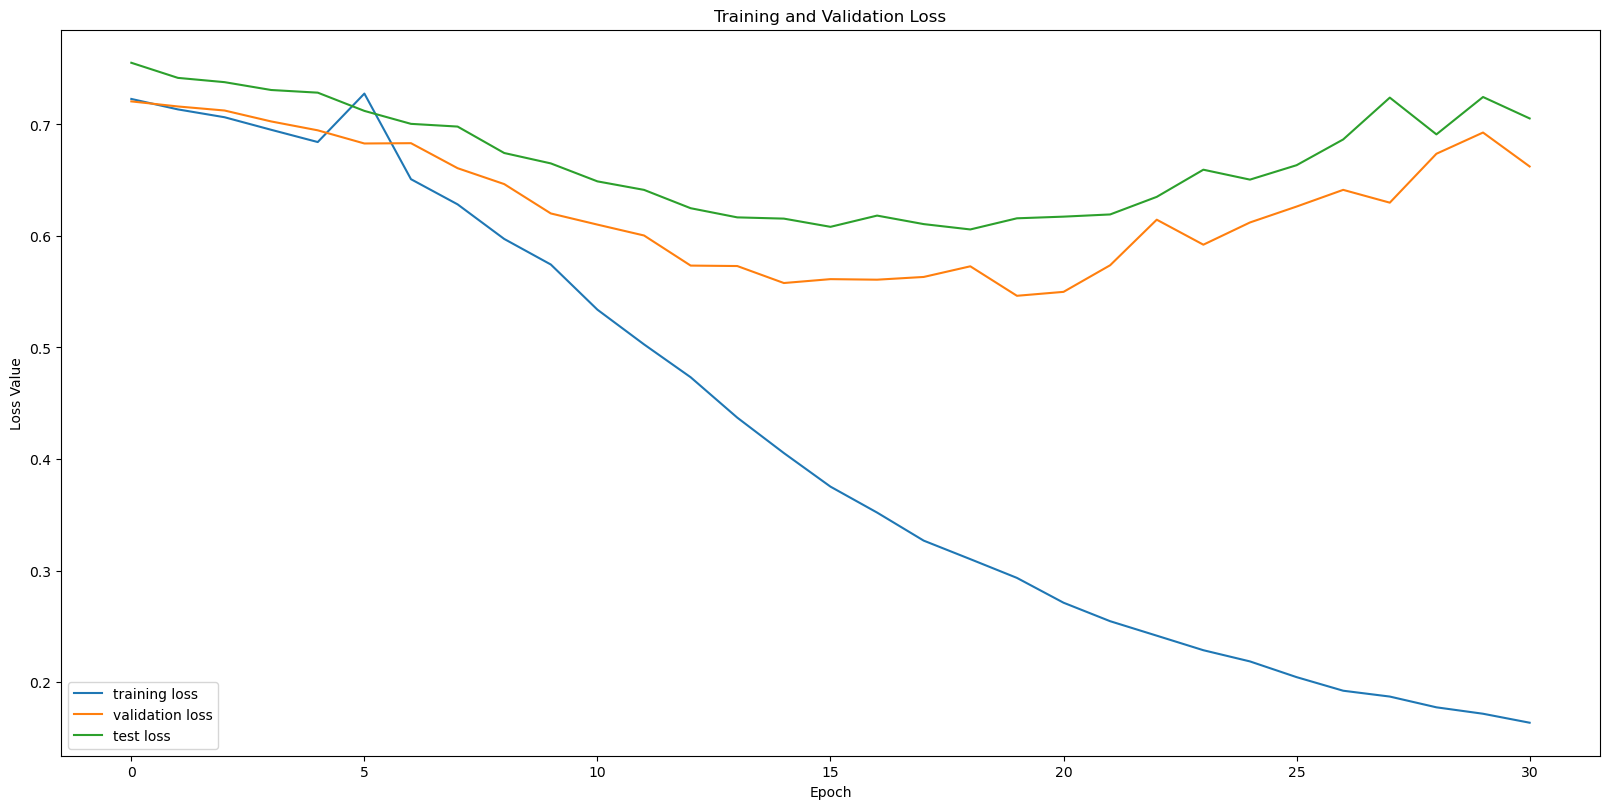

In [861]:
plt.figure(figsize=(16, 8))
sn.lineplot(x=range(len(train_losses)),y=np.array(train_losses) /len(train_loader), label='training loss') #16692)*1000)#len(train_loader))#16692)
sn.lineplot(x=range(len(val_losses)),y=np.array(val_losses) / len(val_loader), label='validation loss')#3603) * 1000)#len(val_loader))#3603)
sn.lineplot(x=range(len(test_losses)),y=np.array(test_losses) / len(test_loader), label='test loss')#3603) * 1000)#len(val_loader))#3603)
plt.legend()
plt.title('Training, Validation & Test Loss')
plt.tight_layout()
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
#plt.savefig('pictures2/losses_fp2_2048_0005_with_test_model.png')

## The metrics we have tracked during training can be plotted here. Alternatively, we could set up W&B to track them in real time

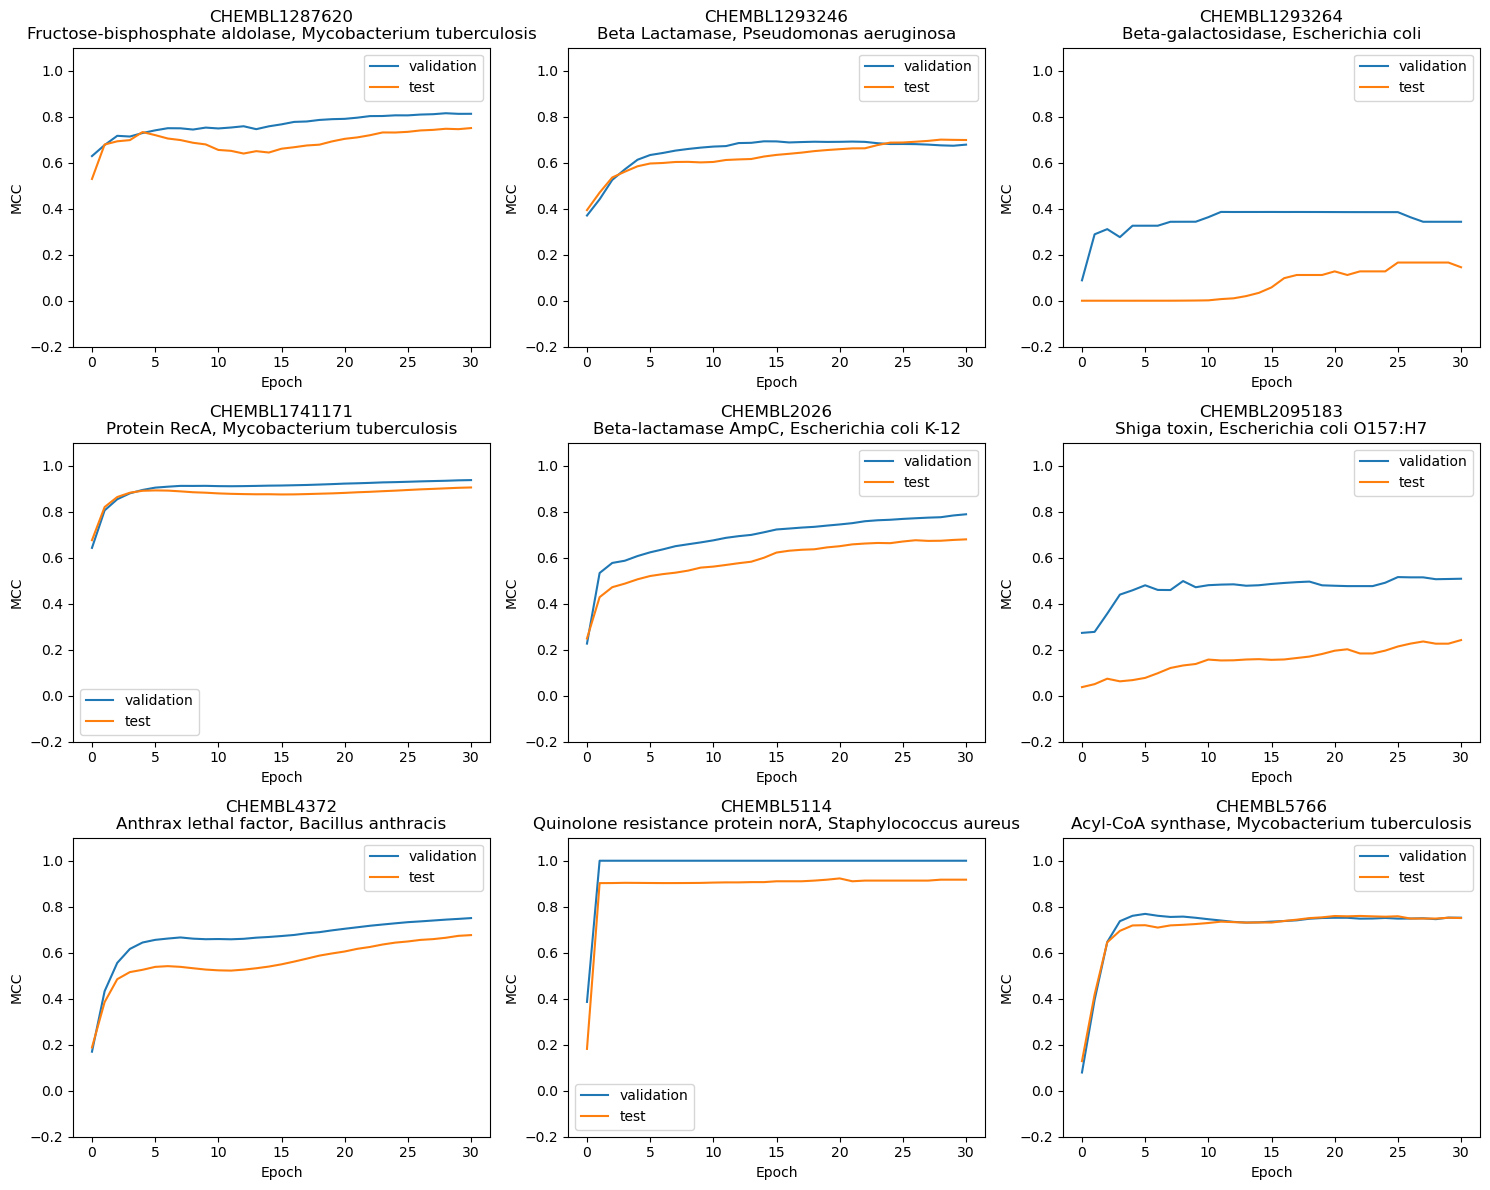

In [950]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
for head,ax in zip(range(9), axs.ravel()): #f1,mcc, auprc, auroc, bedroc, random_bedroc,):
    sn.lineplot(x=range(len(np.array(bedrocs)[:,head])), y=np.array(bedrocs)[:,head], ax=ax, label='validation')
    sn.lineplot(x=range(len(np.array(t_bedrocs)[:,head])), y=np.array(t_bedrocs)[:,head], ax=ax, label='test')
    #ax.hlines(y=y, xmin=0, xmax=18, color='green', label='test')
    ax.set_title(idx_to_target_name[head])
    ax.legend()
    #ax.set_xlim((-1, 19))
    ax.set_ylim((-0.2,1.1))
    ax.set_xlabel('Epoch')
    ax.set_ylabel('BEDROC')
    plt.tight_layout()
#plt.savefig('pictures2/mccs.png')

### Best model

In [931]:
np.argmin(val_losses)

19

In [ ]:
model.load_state_dict(torch.load(f"./{MODEL_PATH}"))

In [ ]:
test_loss, test_loss_by_target, test_sorteds, f1,mcc, auprc, auroc, bedroc, random_bedroc, test_predictions, test_pred_probas, test_trues  = test(model, test_loader, criterion)

In [71]:
prior_classifier = DummyClassifier(strategy='prior')
random_classifier = DummyClassifier(strategy='uniform', random_state=42)

In [72]:
def get_random_predictions(X):
    length = X.shape[0]
    return np.array([random.uniform(0.,1.0) for _ in range(length)])

In [73]:
prior_proba_predictions, random_proba_predictions = [], []
prior_predictions, random_predictions = [], []
for head in range(9):
    prior_classifier = prior_classifier.fit(train_dataset.fps[head], train_dataset.labels[head])
    prior_proba_predictions.append(prior_classifier.predict_proba(test_dataset.fps[head]))
    prior_predictions.append(prior_classifier.predict(test_dataset.fps[head]))
    
    random_proba_predictions.append(get_random_predictions(test_dataset.labels[head]))
    random_classifier = random_classifier.fit(train_dataset.fps[head], train_dataset.labels[head])
    random_predictions.append(random_classifier.predict(test_dataset.fps[head]))

## Determine the distribution of the null hypothesis via bootstrap. Agrees in form with the https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-10-225

In [74]:
random_auprcs_all = []
random_aurocs_all = []
for head in range(9):
    _auprcs = []
    _aurocs = []
    for _ in tqdm(range(1000)):
        random_pred_probas = get_random_predictions(test_dataset.labels[head])
        test_precision_auc, test_recall_auc, test_threshold_auc = precision_recall_curve(test_trues[head], random_pred_probas)
        _auprcs.append(auc(test_recall_auc, test_precision_auc))
        _aurocs.append(roc_auc_score(test_trues[head], random_pred_probas))
    random_auprcs_all.append(_auprcs)
    random_aurocs_all.append(_aurocs)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

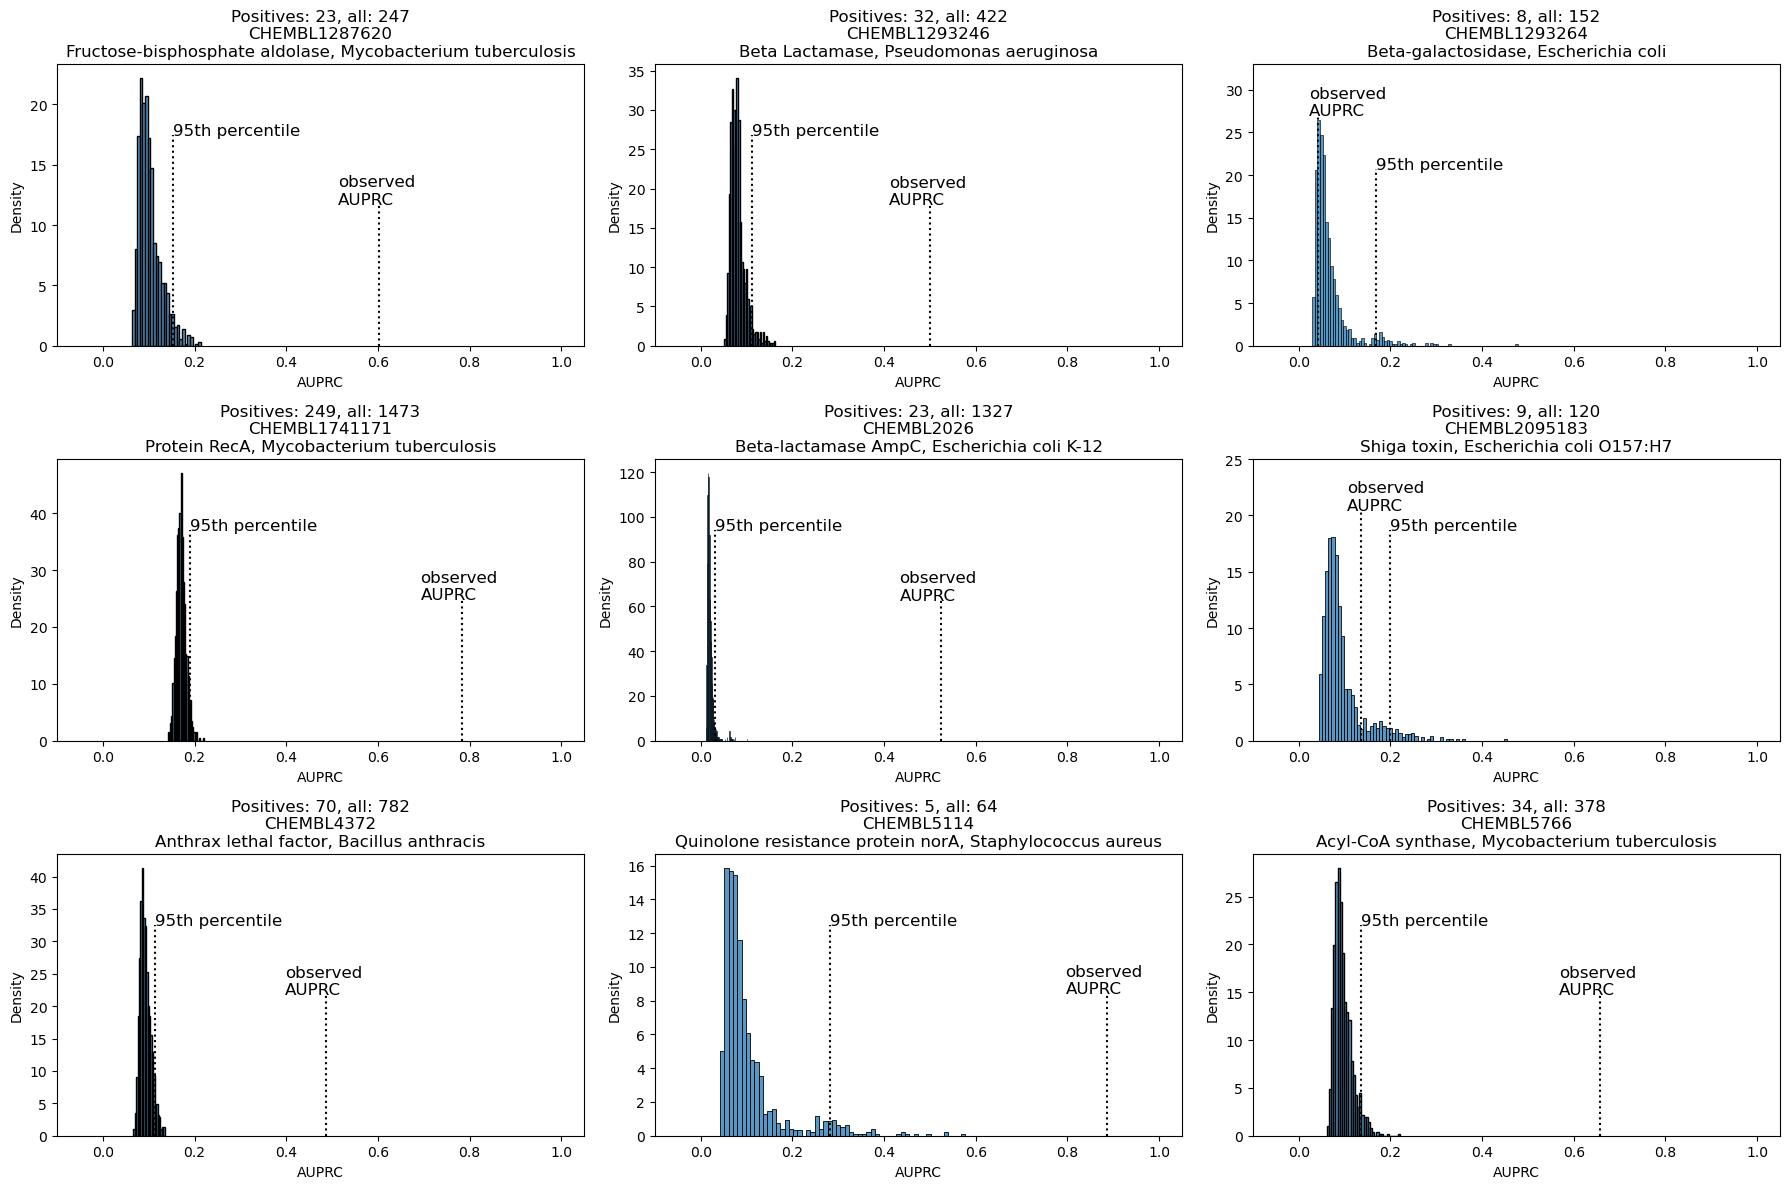

In [96]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(18,12))
for i, ax in zip(range(9), axs.ravel(), ):
    sn.histplot(random_auprcs_all[i], stat='density', ax=ax)
    ax.set_xlim((-0.1,1.05))
    ax.set_title('Positives: '+ str(int(sum(test_labels[i]))) + ', all: ' + str(len(test_labels[i])) + '\n' + idx_to_target_name[i])  
    ax.set_xlabel('AUPRC')
    if i != 5 and i!=2:
        ax.vlines(np.quantile(random_auprcs_all[i], 0.95), ymin=0, ymax=(3 * ax.get_ylim()[1]) / 4, color='black', linestyle = ":")
        ax.vlines(auprc[i],  ymin=0, ymax= ax.get_ylim()[1] / 2, color='black', linestyle = ":")
        ax.text(np.quantile(random_auprcs_all[i], 0.95) , y=(3 * ax.get_ylim()[1]) / 4, s='95th percentile', fontdict ={'fontsize':12})
        ax.text(auprc[i] - 0.09, y=(ax.get_ylim()[1] / 2) + 0.1, s='observed\nAUPRC', fontdict ={'fontsize':12})
        plt.tight_layout()
    elif i == 5:
        ax.set_ylim((0, 25))
        ax.vlines(np.quantile(random_auprcs_all[i], 0.95), ymin=0, ymax=(3 * ax.get_ylim()[1]) / 4, color='black', linestyle = ":")
        ax.vlines(auprc[i],  ymin=0, ymax= 20.5, color='black', linestyle = ":")
        ax.text(np.quantile(random_auprcs_all[i], 0.95) , y=(3 * ax.get_ylim()[1]) / 4, s='95th percentile', fontdict ={'fontsize':12})
        ax.text(auprc[i] - 0.03, y=20.5, s='observed\nAUPRC', fontdict ={'fontsize':12})
        plt.tight_layout()
    else:    
        ax.set_ylim((0, 33))
        ax.vlines(np.quantile(random_auprcs_all[i], 0.95), ymin=0, ymax=((3 * ax.get_ylim()[1]) / 4 )- 4, color='black', linestyle = ":")
        ax.vlines(auprc[i],  ymin=0, ymax=27, color='black', linestyle = ":")
        ax.text(np.quantile(random_auprcs_all[i], 0.95) , y=((3 * ax.get_ylim()[1]) / 4) - 4, s='95th percentile', fontdict ={'fontsize':12})
        ax.text(auprc[i] - 0.02, y=27, s='observed\nAUPRC', fontdict ={'fontsize':12})
        plt.tight_layout()
plt.savefig('pictures_2/auprcs_distribution_ecf4.png')

### Functions for plotting the various metrics

In [79]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, ax):
    sn.lineplot(x=thresholds, y=precisions[:-1], label="Precision", linewidth=2, ax=ax)
    sn.lineplot(color="green",x=thresholds, y=recalls[:-1],label="Recall", linewidth=2, ax=ax)
    ax.legend(loc="best", fontsize=16) 
    ax.xlabel("Threshold", fontsize=16)        
    ax.grid(True)                              

def plot_precision_vs_recall(precisions, recalls,color,label, ax=None):
    sn.lineplot(x=recalls, y=precisions, linewidth=2, color=color,label=label, ax=ax)
    ax.set_xlabel("Recall", fontsize=16)
    ax.set_ylabel("Precision", fontsize=16)
    ax.axis([-0.1, 1.1, -0.1, 1.1])
    ax.grid(True)

    
def plot_roc_curve(fpr, tpr, label, ax=None):
    sn.lineplot(fpr, tpr, linewidth=2, label=label, ax=ax)
    ax.axis([-0.1, 1.1, 0, 1.1])                                  
    #plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    #plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    ax.grid(True)        

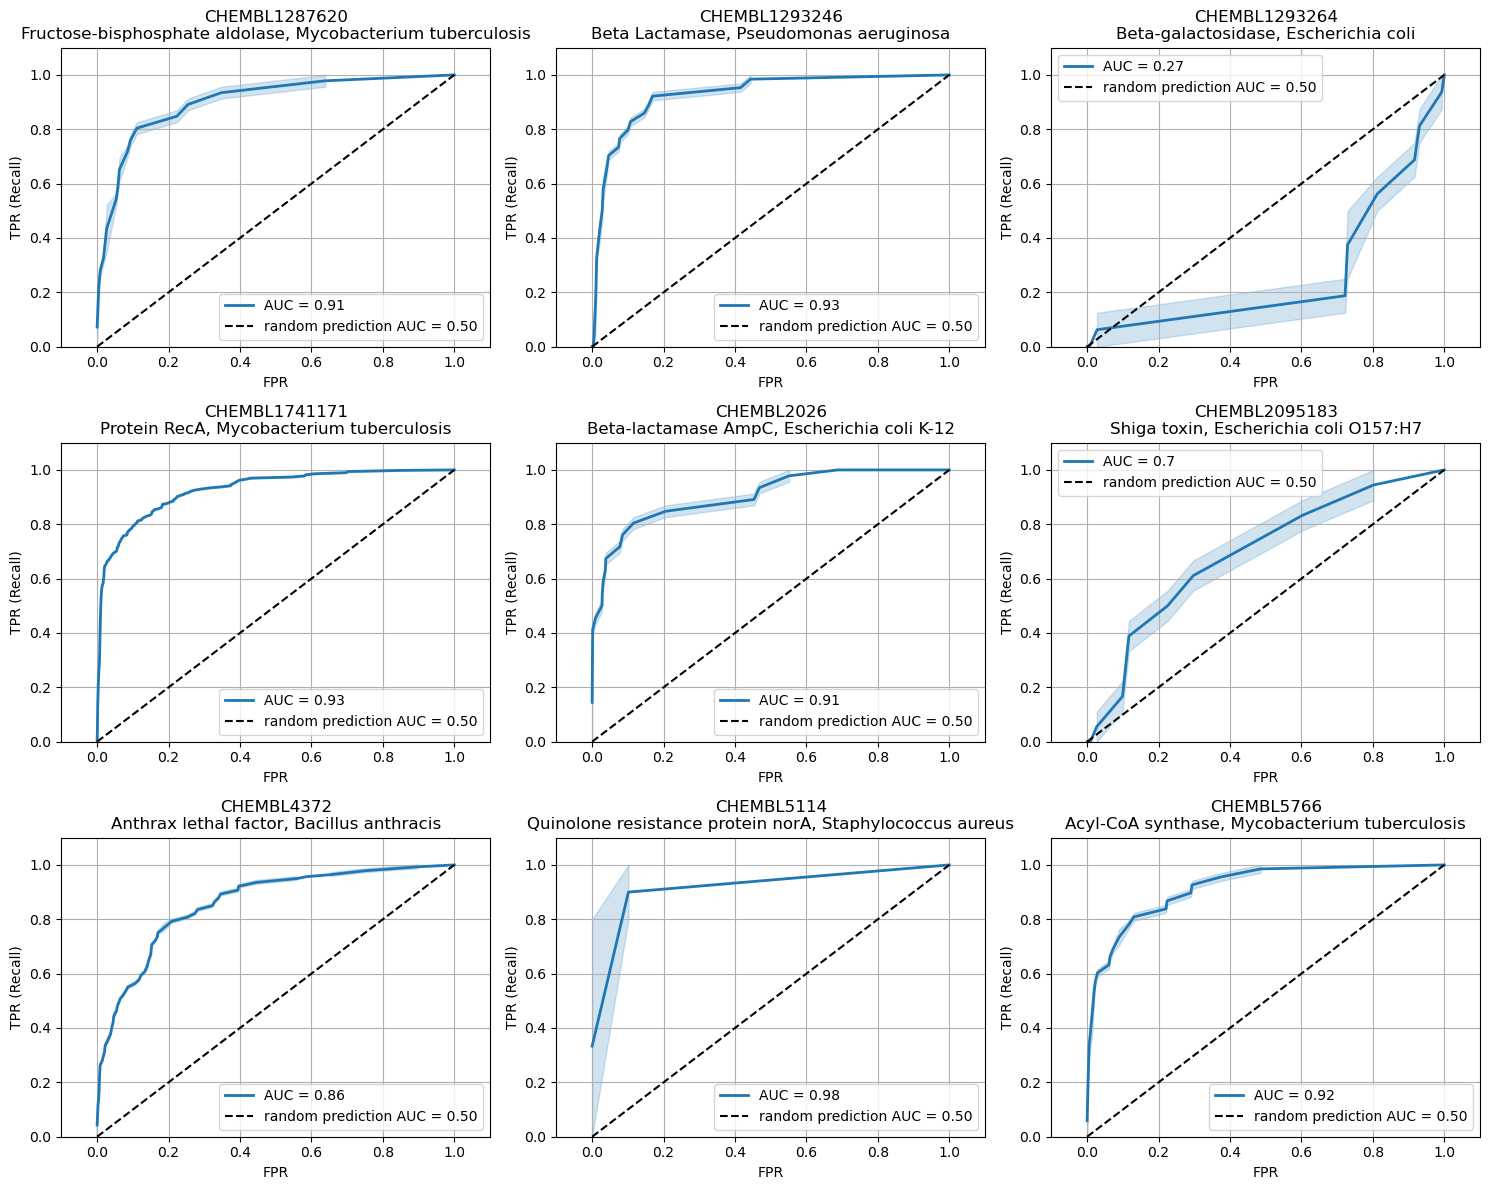

In [84]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
for head,ax in zip(range(9), axs.ravel()): #f1,mcc, auprc, auroc, bedroc, random_bedroc,):
    test_fpr, test_tpr, test_thresholds = roc_curve(test_trues[head], test_pred_probas[head][:])
    plot_roc_curve(test_fpr, test_tpr, f'AUC = {round(auroc[head], 2)}', ax)
    ax.set_title(idx_to_target_name[head])
    ax.plot([0, 1], [0, 1], 'k--', label='random prediction AUC = 0.50')
    ax.legend()
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR (Recall)')
    plt.tight_layout()
plt.savefig('pictures_2/ecfp4_aurocs.png')

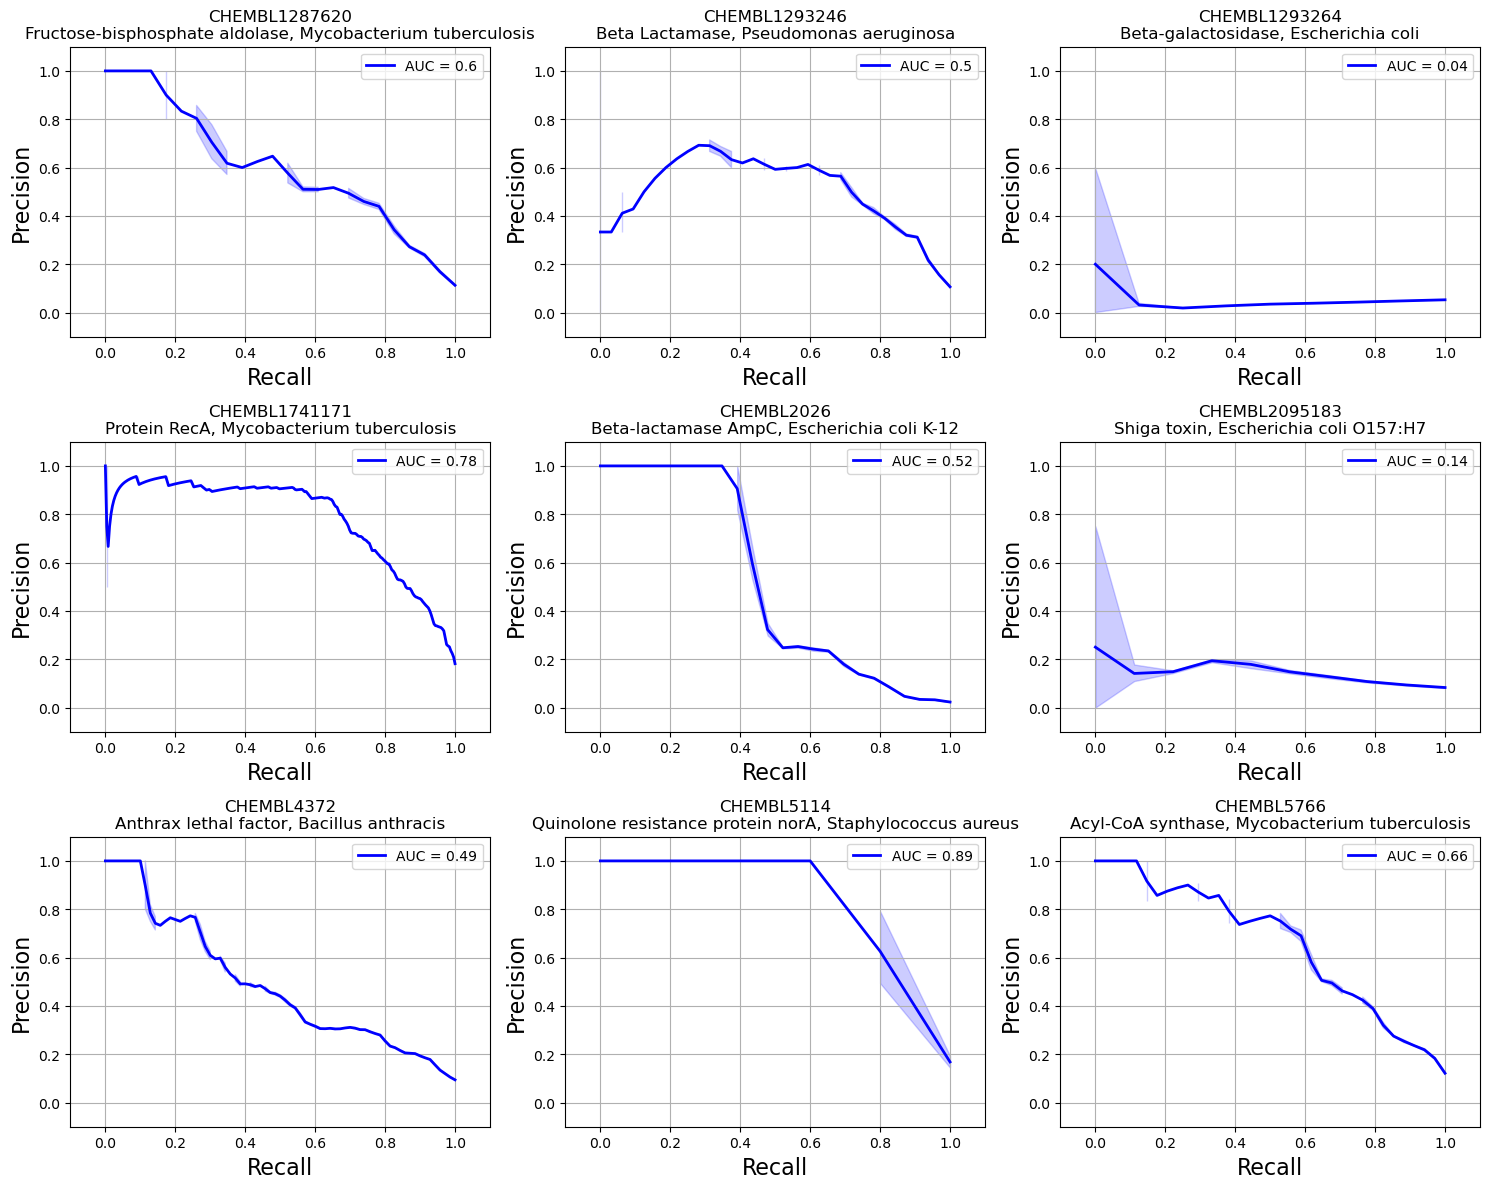

In [87]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
for head,ax in zip(range(9), axs.ravel()): #f1,mcc, auprc, auroc, bedroc, random_bedroc,):
    test_precision_auc, test_recall_auc, test_threshold_auc = precision_recall_curve(test_trues[head], test_pred_probas[head][:])
    
    plot_precision_vs_recall(test_precision_auc, test_recall_auc, 'blue',f'AUC = {round(auc(test_recall_auc, test_precision_auc), 2)}', ax=ax, )
    ax.set_title(idx_to_target_name[head])
    plt.tight_layout()
plt.savefig('pictures_2/ecfp4_auprcs.png')

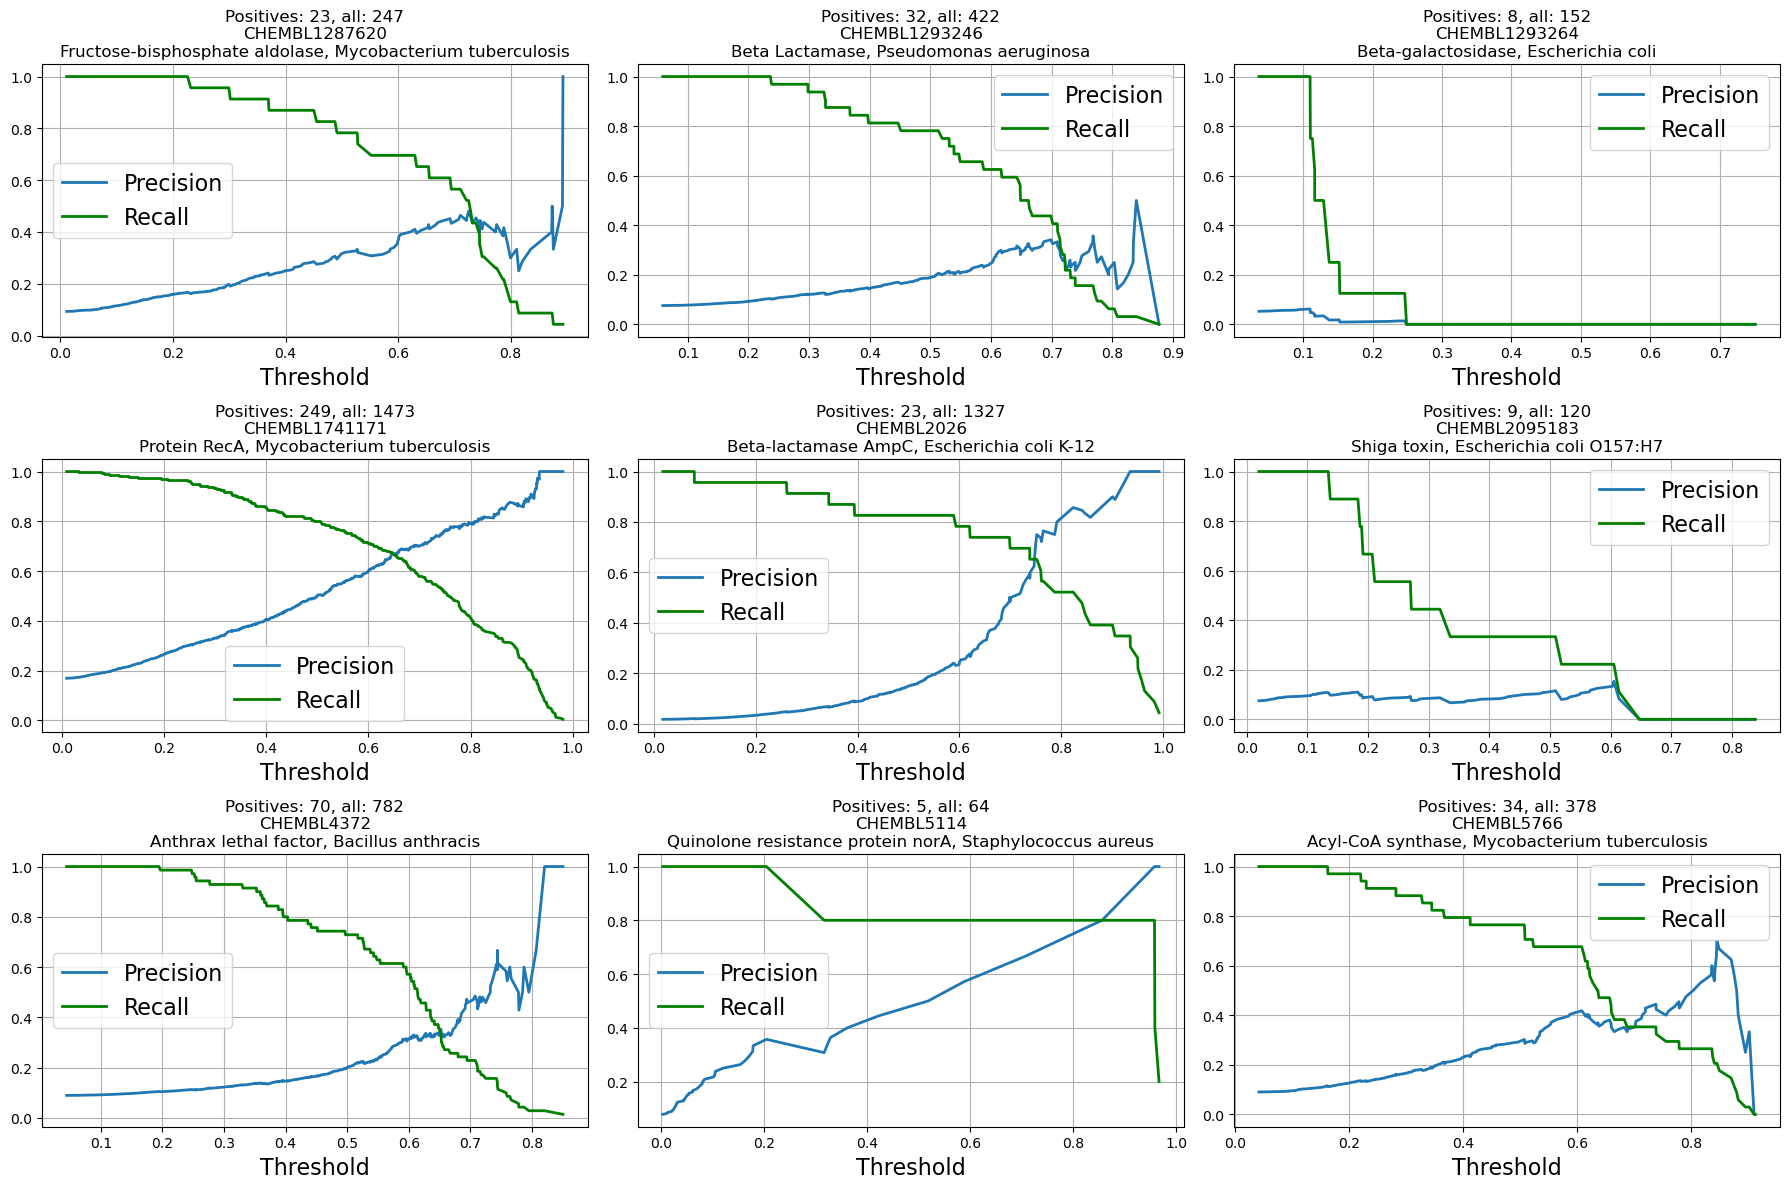

In [621]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(18,12))
for head, ax in zip(range(9), axs.ravel(), ):
    #ax.set_xlim((-0.1,1.05))
    ax.set_title('Positives: '+ str(int(sum(test_labels[head]))) + ', all: ' + str(len(test_labels[head])) + '\n' + idx_to_target_name[head])  
    precision, recall, thresholds = precision_recall_curve(test_trues[head], test_pred_probas[head])
    plot_precision_recall_vs_threshold(precision, recall, thresholds, ax)
    plt.tight_layout()

### Since we can't estimate a probability distribution for the prior classifier, we can test for significant difference in performance using a permutation test

In [ ]:
def permutation_test_between_clfs_prc(y_test, pred_proba_1, pred_proba_2, nsamples=1000):
    precision1, recall1, thresholds1 = precision_recall_curve(y_test, pred_proba_1)
    precision2, recall2, thresholds2 = precision_recall_curve(y_test, pred_proba_2)
    auc1 = auc(recall1, precision1)
    auc2 = auc(recall2, precision2)
    auc_differences = []
    observed_difference = auc1 - auc2
    for _ in range(nsamples):
        mask = np.random.randint(2, size=len(pred_proba_1))
        p1 = np.where(mask, pred_proba_1, pred_proba_2)
        p2 = np.where(mask, pred_proba_2, pred_proba_1)
        precision1, recall1, thresholds1 = precision_recall_curve(y_test, p1)
        precision2, recall2, thresholds2 = precision_recall_curve(y_test, p2)
        auc1 = auc(recall1, precision1)
        auc2 = auc(recall2, precision2)
        auc_differences.append(auc1 - auc2)
    return observed_difference, np.mean(auc_differences >= observed_difference)

In [98]:
def permutation_test_between_clfs_roc(y_test, pred_proba_1, pred_proba_2, nsamples=1000):
    auc_differences = []
    auc1 = roc_auc_score(y_test, pred_proba_1)
    auc2 = roc_auc_score(y_test, pred_proba_2)
    observed_difference = auc1 - auc2
    for _ in range(nsamples):
        mask = np.random.randint(2, size=len(pred_proba_1))
        p1 = np.where(mask, pred_proba_1, pred_proba_2)
        p2 = np.where(mask, pred_proba_2, pred_proba_1)
        auc1 = roc_auc_score(y_test, p1)
        auc2 = roc_auc_score(y_test, p2)
        auc_differences.append(auc1 - auc2)
    return observed_difference, np.mean(auc_differences >= observed_difference)

In [99]:
permu_results_auroc, permu_results_auprc = [], []
for head in tqdm(range(9)):
    permu_results_auroc.append(permutation_test_between_clfs_roc(test_trues[head],test_pred_probas[head], prior_proba_predictions[head][:, 1]))
    permu_results_auprc.append(permutation_test_between_clfs_prc(test_trues[head],test_pred_probas[head], prior_proba_predictions[head][:, 1]))

  0%|          | 0/9 [00:00<?, ?it/s]

In [100]:
permu_results_auroc

[(0.40722049689441, 0.001),
 (0.43277243589743586, 0.0),
 (-0.2326388888888889, 0.929),
 (0.42815707273538606, 0.0),
 (0.40737530008002143, 0.002),
 (0.19669669669669665, 0.16),
 (0.36001203852327446, 0.0),
 (0.47966101694915264, 0.041),
 (0.4208276333789329, 0.0)]

In [101]:
permu_results_auprc

[(0.05617860622110771, 0.372),
 (-0.03677846553724706, 0.596),
 (-0.48347194402519833, 1.0),
 (0.19848886067200466, 0.001),
 (0.014768908024115013, 0.452),
 (-0.4014791306947962, 1.0),
 (-0.05697263397929858, 0.716),
 (0.3463920454545455, 0.194),
 (0.11330748406725977, 0.243)]

## Determine statistical difference with respect to metrics which are suitable for "early detection" 

In [102]:
idx_to_tested_slr = {}
for i, t in idx_to_target_name.items():
    idx_to_tested_slr[i] = 0
    for rank, [score, _, active_bool] in enumerate(test_sorteds[i]):
        if active_bool:
            idx_to_tested_slr[i] += np.log(rank + 1)

In [105]:
idx_to_slr_threshold = {}
for i,t in idx_to_target_name.items():
    print(i, sum(test_labels[i]), len(test_labels[i]))
    idx_to_slr_threshold[i] = sum(test_labels[i]) * np.log(len(test_labels[i])) - gamma(sum(test_labels[i])).ppf(0.95)

0 23.0 247
1 32.0 422
2 8.0 152
3 249.0 1473
4 23.0 1327
5 9.0 120
6 70.0 782
7 5.0 64
8 34.0 378


In [106]:
idx_to_slr_threshold

{0: 95.3011215367394,
 1: 151.6025396777919,
 2: 27.042930364338098,
 3: 1540.957735558493,
 4: 133.97073858393668,
 5: 28.6527759698421,
 6: 382.02335471136183,
 7: 11.640896390160785,
 8: 157.66132044012895}

In [107]:
idx_to_tested_slr

{0: 65.43891686515866,
 1: 104.4116122076607,
 2: 35.34367057298308,
 3: 1200.6766865982197,
 4: 78.47559338537312,
 5: 29.502773151573088,
 6: 291.51495794926655,
 7: 5.575949103146316,
 8: 106.36459867925534}

In [108]:
slr_differences = []
for i,t in idx_to_target_name.items():
    slr_differences.append((idx_to_tested_slr[i] - idx_to_slr_threshold[i]) / idx_to_slr_threshold[i])

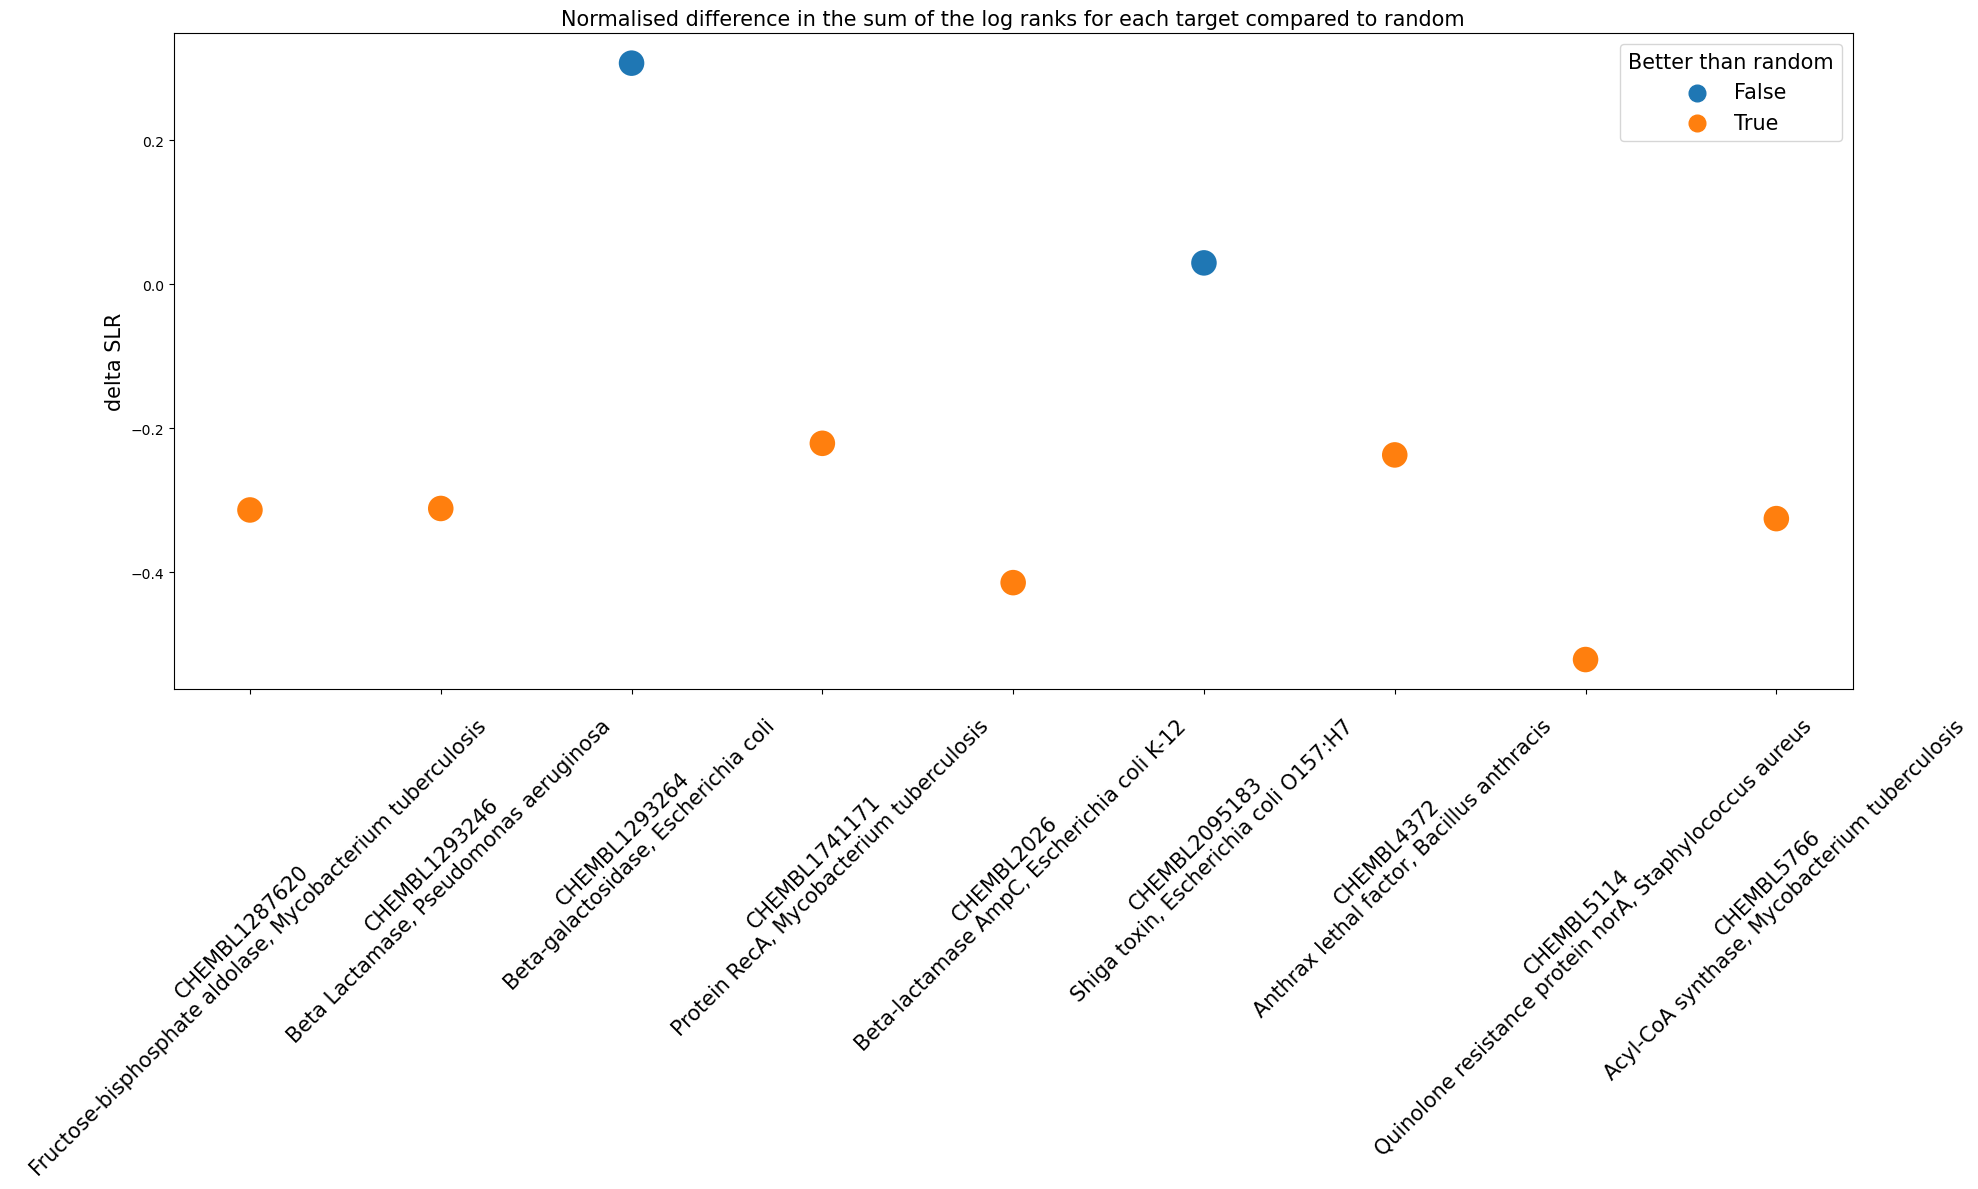

In [111]:
plt.figure(figsize=(20,12))
g=sn.scatterplot(y=slr_differences,x=idx_to_target_name.values(), hue=np.array(slr_differences)<0, s=400, )

g.legend(prop={'size': 15}, markerscale=2)
g.legend_.set_title('Better than random', prop={'size': 15})

plt.title('Normalised difference in the sum of the log ranks for each target compared to random', fontsize=15)
plt.ylabel('delta SLR', fontsize=15)
plt.xticks(rotation=45, fontsize=15)
plt.tight_layout()
plt.savefig('pictures_2/slr_ecfp4.png')

In [114]:
idx_to_bedroc = {}
for i, t in idx_to_target_name.items():
    idx_to_bedroc[i] = Scoring.CalcBEDROC(test_sorteds[i], 2, 20)

In [115]:
random_bedrocs = {}
for t in tqdm(range(9)):
    random_bedrocs[t] = []
    for _ in range(10000):
        to_shuffle = test_sorteds[t].copy()
        np.random.shuffle(to_shuffle)
        random_bedrocs[t].append(Scoring.CalcBEDROC(to_shuffle, 2, 20))

  0%|          | 0/9 [00:00<?, ?it/s]

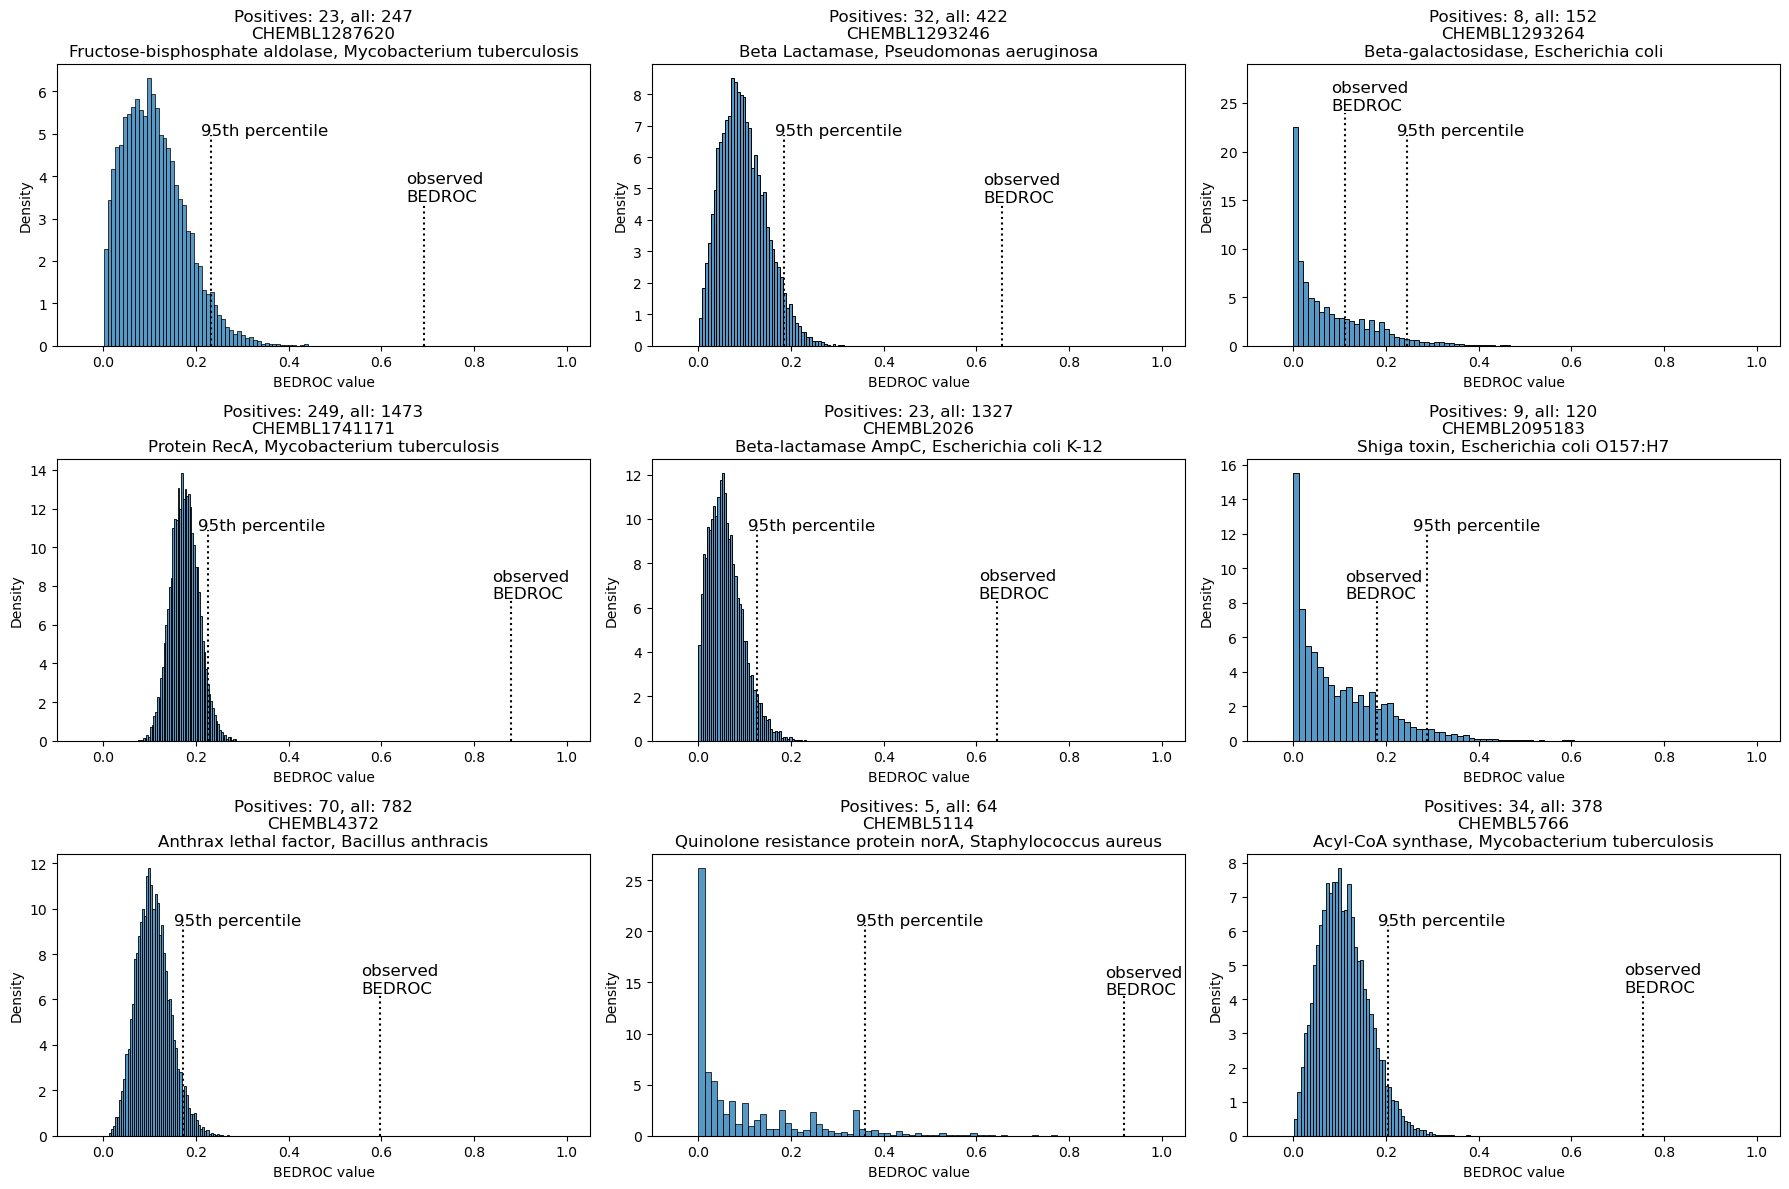

In [116]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
for i, ax in zip(range(9), axs.ravel(), ):
    sn.histplot(random_bedrocs[i], stat='density', ax=ax)
    ax.set_xlim((-0.1,1.05))
    ax.set_title('Positives: '+ str(int(sum(test_labels[i]))) + ', all: ' + str(len(test_labels[i])) + '\n' + idx_to_target_name[i])  
    ax.set_xlabel('BEDROC value')
    if i != 2 and i != 5:
        ax.vlines(np.quantile(random_bedrocs[i], 0.95), ymin=0, ymax=(3 * ax.get_ylim()[1]) / 4, color='black', linestyle = ":")
        ax.vlines(idx_to_bedroc[i],  ymin=0, ymax= ax.get_ylim()[1] / 2, color='black', linestyle = ":")
        ax.text(np.quantile(random_bedrocs[i], 0.95) - 0.02, y=(3 * ax.get_ylim()[1]) / 4, s='95th percentile', fontdict ={'fontsize':12})
        ax.text(idx_to_bedroc[i] - 0.04, y=(ax.get_ylim()[1] / 2) + 0.1, s='observed\nBEDROC', fontdict ={'fontsize':12})
        plt.tight_layout()
    elif i == 5:
        ax.vlines(np.quantile(random_bedrocs[i], 0.95), ymin=0, ymax=(3 * ax.get_ylim()[1]) / 4, color='black', linestyle = ":")
        ax.vlines(idx_to_bedroc[i],  ymin=0, ymax= ax.get_ylim()[1] / 2, color='black', linestyle = ":")
        ax.text(np.quantile(random_bedrocs[i], 0.95) - 0.03, y=(3 * ax.get_ylim()[1]) / 4, s='95th percentile', fontdict ={'fontsize':12})
        ax.text(idx_to_bedroc[i] - 0.07, y=(ax.get_ylim()[1] / 2) + 0.1, s='observed\nBEDROC', fontdict ={'fontsize':12})
        plt.tight_layout()
    else:    
        ax.set_ylim((0, 29))
        ax.vlines(np.quantile(random_bedrocs[i], 0.95), ymin=0, ymax=(3 * ax.get_ylim()[1]) / 4, color='black', linestyle = ":")
        ax.vlines(idx_to_bedroc[i],  ymin=0, ymax=24, color='black', linestyle = ":")
        ax.text(np.quantile(random_bedrocs[i], 0.95) - 0.02, y=(3 * ax.get_ylim()[1]) / 4, s='95th percentile', fontdict ={'fontsize':12})
        ax.text(idx_to_bedroc[i] - 0.03, y=24.3, s='observed\nBEDROC', fontdict ={'fontsize':12})
        plt.tight_layout()
    #ax.set_ylim((0., 11.5))
plt.savefig('pictures_2/bedroc_targets_random_ecfp4.png')

## Determine the applicability domain
### As explained in https://mediatum.ub.tum.de/doc/1004002/1004002.pdf -> one way to measure this could be via the minimum Tanimoto distance (maximum Tanimoto similarity) to a compound in the training set

In [221]:
simis_test_to_train = {} # stores the max similarity of a test set molecule to any train set molecule
dfs_dict = {} # dictionary to store the datafranes for each target

for head in tqdm(range(9)):
    max_simis = []

    df = pd.DataFrame(columns=['mol_index','max_similarity','Test Label', 'Train Label of Most Similar'])
    train_mol_label = []
    
    for i, test_fp in enumerate(test_dataset.bv_fps[head]):
        _simis = []
        for j, train_fp in enumerate(train_dataset.bv_fps[head]):
            curr_simi = DataStructs.TanimotoSimilarity(test_fp, train_fp)
            _simis.append(curr_simi)
        max_simis.append(max(_simis))
        train_mol_label.append(train_dataset.labels[head][np.argmax(_simis)])
    
    df['mol_index'] = range(len(max_simis))
    df['max_similarity'] = max_simis
    df['Test Label'] = test_dataset.labels[head]
    df['Train Label of Most Similar'] = train_mol_label
    dfs_dict[head] = df
    simis_test_to_train[head] = max_simis


  0%|          | 0/9 [00:00<?, ?it/s]

In [229]:
def concat_test_train_label(row):
    return str(int(row['Test Label'])) + '_' +str(int(row['Train Label of Most Similar']))

In [235]:
for head in tqdm(range(9)):
    dfs_dict[head]['Test_Train Label'] = dfs_dict[head].apply(concat_test_train_label, axis=1)

  0%|          | 0/9 [00:00<?, ?it/s]

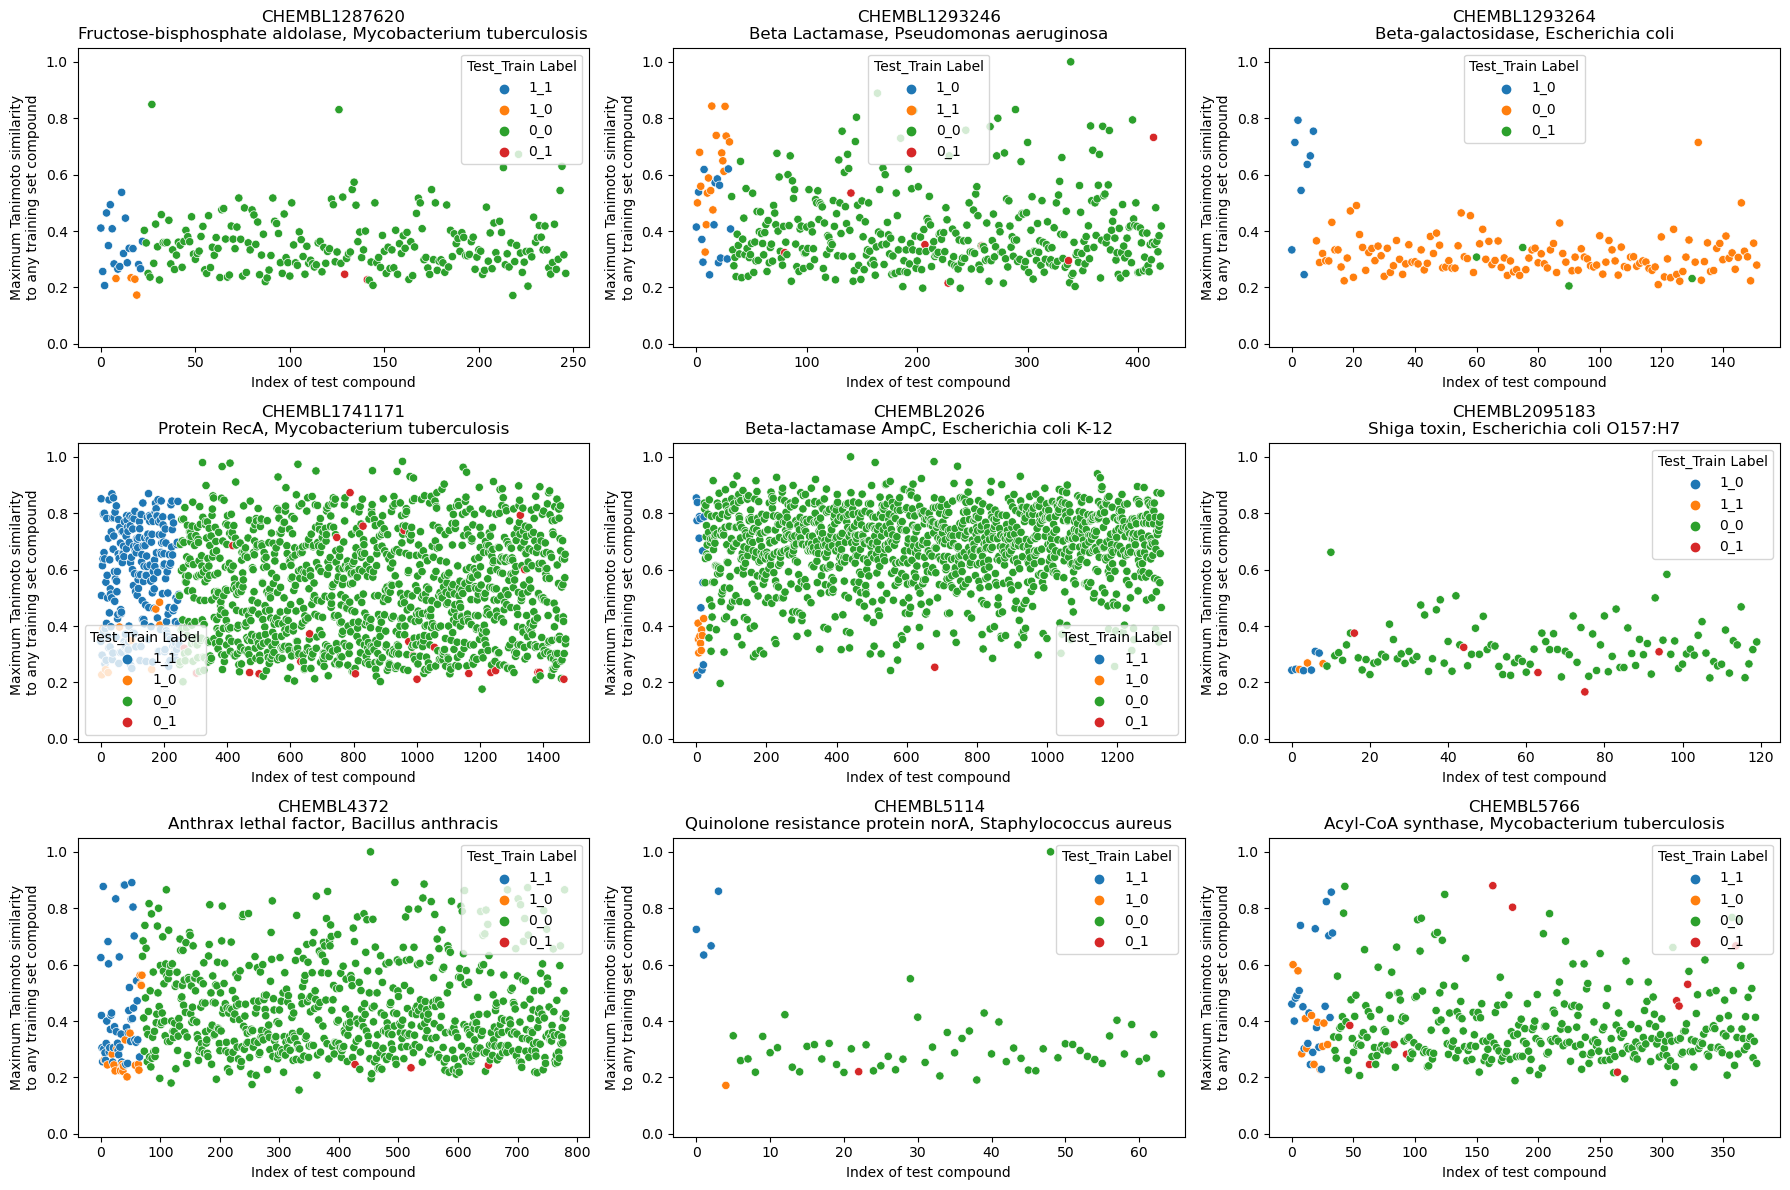

In [236]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
for head, ax in zip(range(9), axs.ravel(),):
    sn.scatterplot(data=dfs_dict[head], x='mol_index', y='max_similarity', hue='Test_Train Label', ax=ax)
    #sn.scatterplot(x=range(len(simis_test_to_train[head])), y=simis_test_to_train[head],  ax=ax)
    ax.set_ylim((-0.01,1.05))
    #ax.set_title('Positives: '+ str(int(sum(test_labeals[i]))) + ', all: ' + str(len(test_labels[i])) + '\n' + idx_to_target_name[i])  
    ax.set_xlabel('Index of test compound')
    ax.set_ylabel('Maximum Tanimoto similarity\nto any training set compound')
    ax.set_title(idx_to_target_name[head])
    plt.tight_layout()
plt.savefig('pictures_2/applicability_domain_by_labels.png')

## There seems to be a tendency for the models that perform better to have test sets that are more simialar to the training sets
### However, in order to determine the threshold of T. similarity under which the predictions become unreliable there should be tests like, for example, check which molecules the model got wrong (FP, FN) and then see their similarity to the training set moleucles; perhaps also the similarity of the nearest 5-10 molecules in the training set

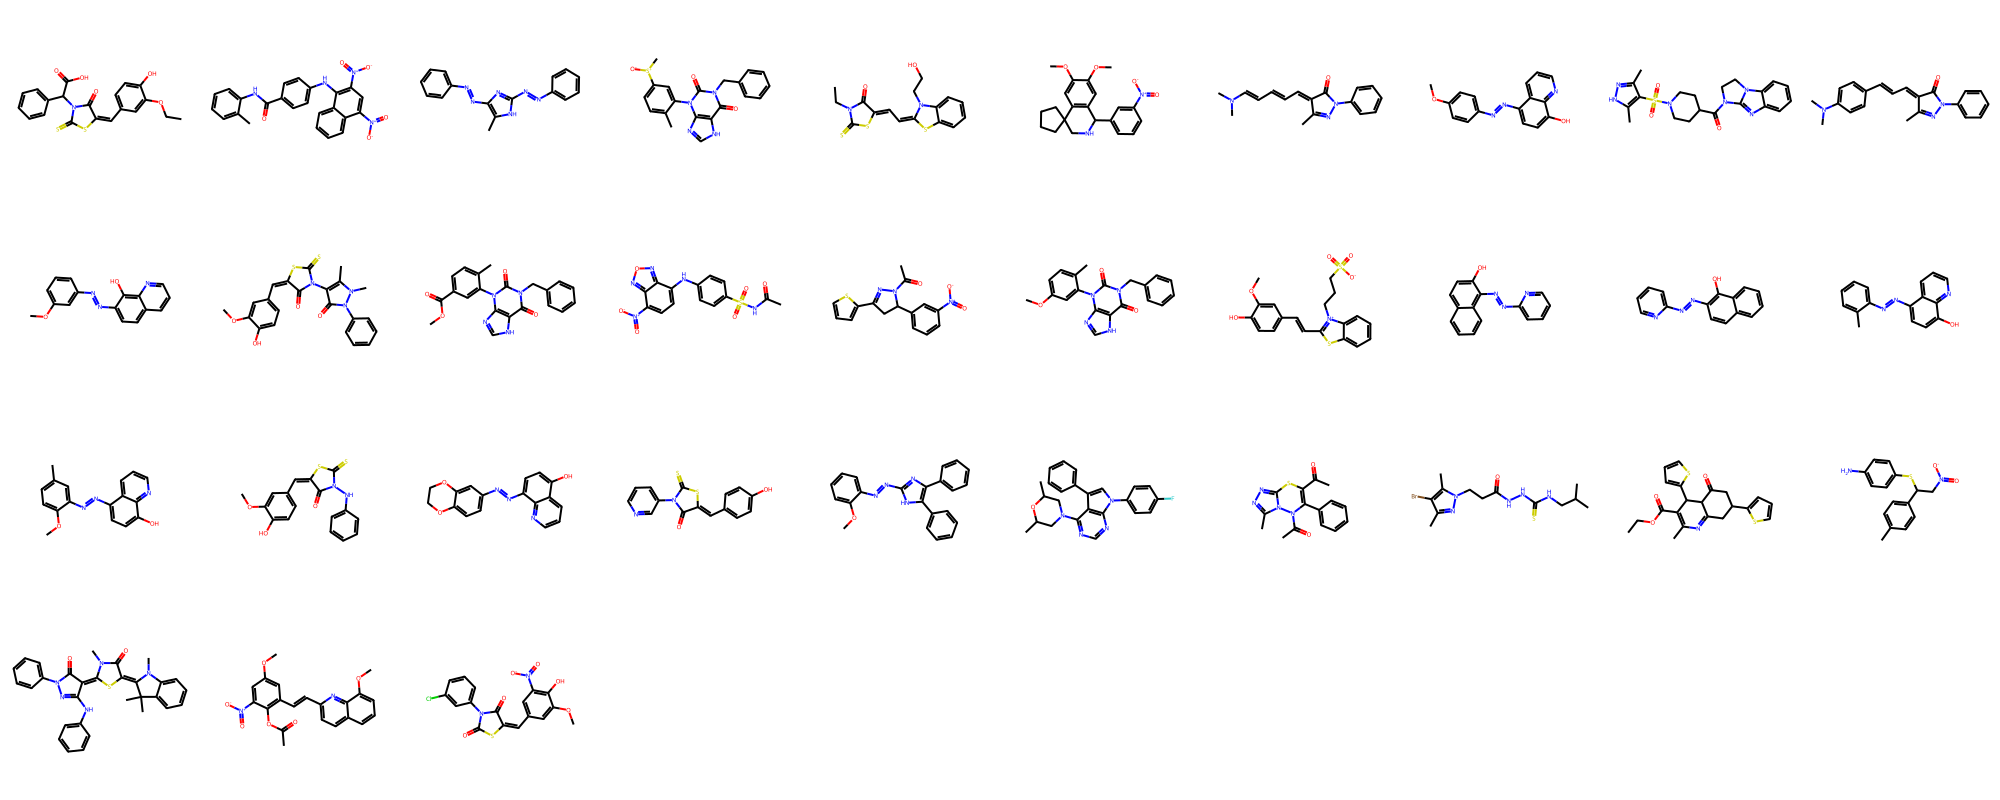

In [206]:
Draw.MolsToGridImage(np.array(train_dataset.all_mols_list[2])[np.where(train_dataset.labels[2]==1., True, False)], molsPerRow=10)

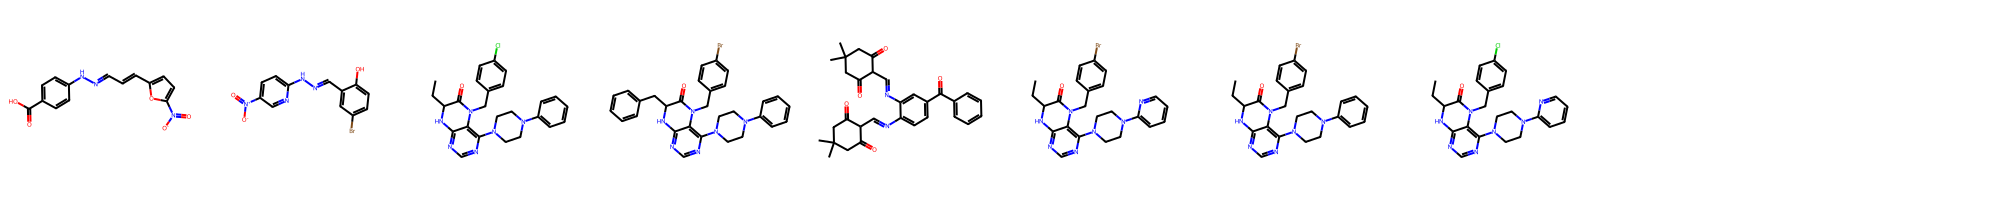

In [207]:
Draw.MolsToGridImage(np.array(test_dataset.all_mols_list[2])[np.where(test_dataset.labels[2]==1., True, False)], molsPerRow=10)